In [1]:
#my stuff
import icu_data_defs
import transformers
import utils
import features
from constants import column_names,variable_type,clinical_source
import units
import mimic
import logger

#other stuff
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

#make pretty pictures
import seaborn as sns
%matplotlib inline

In [ ]:
#HELPER FUNCTIONS

def run_crossval(pipeline,X,y):
    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=10)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error',cv=10)

    print 'Cross Validation, K-Fold'
    print 'R^2: {}, {}'.format(scores_r2.mean(),scores_r2.std())
    print 'RMSE: {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std())

    cv_shuffle = ShuffleSplit(n_splits=10,test_size=0.1)

    scores_r2 = cross_val_score(pipeline,X,y, scoring='r2',cv=cv_shuffle)
    scores_nmse = cross_val_score(pipeline,X,y, scoring='neg_mean_squared_error', cv=cv_shuffle)

    print '\nCross Validation, ShuffleSplit'
    print 'R^2: {}, {}'.format(scores_r2.mean(),scores_r2.std())
    print 'RMSE: {}, {}'.format(np.sqrt(-1.0*scores_nmse).mean(),np.sqrt(-1.0*scores_nmse).std())
    return

"""
Getting lactate labels (next and delta)
"""
def get_labels_next_lac(lactate_series):
    return lactate_series.shift(-1).dropna().iloc[:,0]

def get_labels_delta_lac(lactate_series):
    id_grouped = lactate_series.groupby(level='id')
    lac_filled = id_grouped.ffill()
    lac_next = id_grouped.shift(-1)
    lac_all = lac_filled
    lac_all.columns = ['last']
    lac_all['next'] = lac_next
    lac_all = lac_all.dropna()
    return lac_all['next'] - lac_all['last']


"""
Visualize data
"""
#Visualize
def viz_per_feature(df_features,label_dict):  
    plot_cnt = len(label_dict)+1
    
    df_corr = pd.DataFrame(index=df_features.columns,columns=label_dict.keys())
    
    for col_name in df_features:
        print col_name
        col = df_features[col_name]
        display(col.describe().apply(lambda x: '%.4f' % x).to_frame())
        #determine # of filled values
        mode = col.mode()[0]
        print mode
        mode_count = (col == mode).sum()
        print "MODE:",mode
        print mode_count
        print mode_count/float(col.shape[0])


        # plot histogram of column (all of df_train)
        fig, axarr  = plt.subplots(1,plot_cnt,figsize=(5*(plot_cnt), 5))
        ax = plt.subplot(1, plot_cnt, 1)
        std = col.std()
        mean = col.mean()
        col.loc[(col < (mean + 3.0*std)) & (col > (mean - 3.0*std))].hist()
        ax.set_title('{}_{}\n{}'.format(col_name[0],col_name[1],col_name[2:]))
        ax.set_xlabel(col_name[-2])
        ax.set_ylabel('COUNT')

        #plot this column vs. each label
        for i,label_name in enumerate(label_dict.keys()):
            y = label_dict[label_name]
            
            x = col.loc[y.index]
            ax = plt.subplot(1, plot_cnt, 2+i)
            sns.regplot(x, y)
            corr = np.corrcoef(x, y)[0][1]
            ax.set_title('{}_{} vs. {} \n PCC (r) = {}'.format(col_name[0],col_name[1],label_name,corr))
            df_corr.loc[col_name,label_name]=corr
            ax.set_xlabel(col_name[-2])
            ax.set_ylabel(label_name)
        
        plt.tight_layout()
        plt.show()
    
    return df_corr
        
"""
Test/train/validate split
"""

def test_train_val_split(all_ids=None,test_size=0.1,random_state=42,print_ids=False):

    if all_ids is None:
        all_ids = mimic.get_all_hadm_ids()
    
    validate_size = test_size/(1-test_size)
    train_size = (1-test_size)*(1-validate_size)
    #these test IDs will never be touched again. They are sacred
    train_val_ids,test_ids = train_test_split(all_ids,test_size=test_size,random_state=random_state)
    train_ids,validate_ids = train_test_split(train_val_ids,test_size=validate_size,random_state=random_state)

    if print_ids:
        print 'Train {}:'.format(int(train_size*100)), len(train_ids),'>',train_ids[:5],'...'
        print 'Validate {}:'.format(int(train_size*100)), len(validate_ids),'>',validate_ids[:5],'...'
        print 'Test {}:'.format(int(test_size*100)), len(test_ids),'>',test_ids[:5],'...'
    return train_ids,validate_ids,test_ids

# Setup

In [7]:
random_state=42
#test/train/val split
train_ids,validate_ids,test_ids = test_train_val_split(print_ids=True,random_state=random_state);

# Load Our Data Dict
data_dict = icu_data_defs.data_dictionary('config/data_definitions.xlsx')
display(data_dict.get_defs())

#init ETL Manager => mimic_extract data
hdf5_fname = 'data/mimic_extract.h5'
mimic_etlM = mimic.MimicETLManager(hdf5_fname,'config/mimic_item_map.csv',data_dict)

#init feature factory using data_dict, etl_manager
factory = features.DataSetFactory(features=None,
                                      resample_freq=None,
                                      data_dict=data_dict,
                                      ETL_manager=mimic_etlM,
                                      hdf5_fname_target=None,
                                      panel_id=12 #limit to simple data
                                  )

#create all features
m_ureg = units.MedicalUreg()
is_summable = lambda x: m_ureg.is_volume(str(x)) or m_ureg.is_mass(str(x))

"""
Data Specs
"""
qn_not_sum = {
    column_names.VAR_TYPE : variable_type.QUANTITATIVE,
    column_names.UNITS: lambda units: not is_summable(units)
}

weight = {
    column_names.COMPONENT : data_dict.components.WEIGHT_BODY
}

intervention_summable = {
    column_names.CLINICAL_SOURCE : clinical_source.INTERVENTION,
    column_names.UNITS: is_summable
}

uop_summable = {
    column_names.COMPONENT : data_dict.components.OUTPUT_URINE,
    column_names.UNITS: is_summable
}

not_nominal = {
    column_names.VAR_TYPE : [variable_type.QUANTITATIVE, variable_type.ORDINAL]
}

is_nominal = {
    column_names.VAR_TYPE : variable_type.NOMINAL
}

"""
Features
"""
# MEAN & LAST
# For all non-summable quantities: 
# 1. ffill values
# 2. Then resample and aggregate 
# 3. Then fill with mean of means
f_qn_mean = features.Feature('MEAN','mean',
                               data_specs=[qn_not_sum,weight],
                               pre_processor=transformers.GroubyAndFFill(level=column_names.ID),
                               fillna_method=transformers.fill_mean()
                            )

f_qn_most_recent = features.Feature('LAST','last',
                                       data_specs=[qn_not_sum,weight],
                                       pre_processor=transformers.GroubyAndFFill(level=column_names.ID),
                                       fillna_method=transformers.fill_mean()
                                   )
# STD - fill NaN with 0
f_qn_std = features.Feature('STD','std',
                                data_specs=[not_nominal],
                                fillna_method=transformers.fill_zero()
                           )

# SUM - for UOP volumes and intervention volumes/masses
f_sum = features.Feature('SUM','sum',
                             data_specs=[intervention_summable,uop_summable],
                             fillna_method=transformers.fill_zero()
                        )

#only COUNT ordinal or quantitative data
f_count = features.Feature('COUNT','count',
                           data_specs=[not_nominal],
                           fillna_method=transformers.fill_zero())

#use SUM for nominal data (0's will be counted if we use count)
f_count_nom = features.Feature('COUNT','sum',
                             data_specs=[is_nominal],
                             fillna_method=transformers.fill_zero()
                        )

"""
Lactate Label
"""
# Label is lactate. just resampling; no preprocessing or filling
label = features.Feature('LABEL','mean',{
                                column_names.COMPONENT : data_dict.components.LACTATE,
                                column_names.VAR_TYPE : variable_type.QUANTITATIVE
                            })

Train 80: 47180 > [139698, 127590, 178959, 139276, 196600] ...
Validate 80: 5898 > [112338, 107467, 158733, 144544, 115417] ...
Test 10: 5898 > [167957, 164747, 124147, 184424, 136508] ...


component       units variable_type  \
def_id                                                                          
0                                        heart rate   beats/min            qn   
1                           blood pressure systolic        mmHg            qn   
2                          blood pressure diastolic        mmHg            qn   
3                               blood pressure mean        mmHg            qn   
4                                  respiratory rate    insp/min            qn   
5                                  temperature body        degF            qn   
6                  oxygen saturation pulse oximetry     percent            qn   
7                                       weight body          kg            qn   
8                                      output urine          mL            qn   
9                                      output urine       mL/hr            qn   
10                                     output urine    mL/kg/hr            qn   
11                         glasgow coma scale motor    no_units           ord   
12                   glasgow coma scale eye opening    no_units           ord   
13                        glasgow coma scale verbal    no_units           ord   
14                                    normal saline          mL            qn   
15                                    normal saline       mL/hr            qn   
16                                 lactated ringers          mL            qn   
17                                 lactated ringers       mL/hr            qn   
18                                   norepinephrine         mcg            qn   
19                                   norepinephrine     mcg/min            qn   
20                                   norepinephrine  mcg/kg/min            qn   
21                                      vasopressin       units            qn   
22                                      vasopressin   units/min            qn   
23                                          lactate      mmol/L            qn   
24                                          lactate       mg/dL            qn   
25                                       hemoglobin        g/dL            qn   
26                           white blood cell count    x10e3/uL            qn   
27                             red blood cell count    x10e6/uL            qn   
28                                       hematocrit     percent            qn   
29                          mean corpuscular volume          fL            qn   
...                                             ...         ...           ...   
44                                    glucose serum      mmol/L            qn   
45                                    glucose serum       mg/dL            qn   
46                              glucose fingerstick      mmol/L            qn   
47                              glucose fingerstick       mg/dL            qn   
48                              calcium total serum      mmol/L            qn   
49                              calcium total serum       mg/dL            qn   
50                            calcium ionized serum      mmol/L            qn   
51                            calcium ionized serum       mg/dL            qn   
52                                  magnesium serum       mg/dL            qn   
53                                phosphorous serum       mg/dL            qn   
54                                 prothrombin time     seconds            qn   
55                      partial thromboplastin time     seconds            qn   
56                   international normalized ratio    no_units            qn   
57              partial pressure of oxygen arterial        mmHg            qn   
58      partial pressure of carbon dioxide arterial        mmHg            qn   
59                       oxygen saturation arterial     percent            qn   
60                                      pH arterial    no_units          

# Get features

In [8]:
#start with a smaller data set
reload(logger)

train_subset = pd.Series(train_ids).sample(frac=0.2, random_state=random_state).sort_values().tolist()

print train_subset[:5], len(train_subset)

[100014L, 100029L, 100039L, 100046L, 100052L] 9436


In [9]:
factory.hdf5_fname_target = 'data/combine_like.h5'
factory.resample_freq='2H'
factory.pre_processors = Pipeline([
                                ('drop_small_columns',transformers.remove_small_columns(threshold=100)),
                                ('drop_low_id_count',transformers.record_threshold(threshold=20)),
                                ('combine_like_columns',transformers.combine_like_cols())
                            ])
factory.features = [f_qn_mean,f_qn_most_recent,f_qn_std,f_sum,f_count,f_count_nom,label]
factory.get_params()

{'ETL_manager': <mimic.MimicETLManager at 0xe103630>,
 'data_dict': <icu_data_defs.data_dictionary at 0x1067d940>,
 'features': [<features.Feature at 0xe65ae48>,
 'force_preprocessing': True,
 'hdf5_fname_target': 'data/combine_like.h5',
 'panel_id': 12,
 'pre_processors': Pipeline(steps=[('drop_small_columns', remove_small_columns(threshold=100)), ('drop_low_id_count', record_threshold(threshold=20)), ('combine_like_columns', combine_like_cols())]),
 'pre_processors__combine_like_columns': combine_like_cols(),
 'pre_processors__drop_low_id_count': record_threshold(threshold=20),
 'pre_processors__drop_low_id_count__threshold': 20,
 'pre_processors__drop_small_columns': remove_small_columns(threshold=100),
 'pre_processors__drop_small_columns__threshold': 100,
 'pre_processors__steps': [('drop_small_columns',
   remove_small_columns(threshold=100)),
  ('drop_low_id_count', record_threshold(threshold=20)),
  ('combine_like_columns', combine_like_cols())],
 'resample_freq': '2H',
 'save_

In [10]:
df_train = factory.fit_transform(train_subset)

(2017-08-03 11:32:22) FEATURIZE... #F=7, #ids=9436, fit->True
(2017-08-03 11:32:22)>> PRE-PROCESSING & JOIN: #C=18, ['blood pressure diastolic', 'blood pressure mean', 'blood pressure systolic', 'glasgow coma scale eye opening', 'glasgow coma scale motor', 'glasgow coma scale verbal', 'heart rate', 'hemoglobin', 'lactate', 'lactated ringers', 'norepinephrine', 'normal saline', 'output urine', 'oxygen saturation pulse oximetry', 'respiratory rate', 'temperature body', 'vasopressin', 'weight body']
(2017-08-03 11:32:24)>>>> blood pressure diastolic - 1/18
(2017-08-03 11:32:24)>>>>>> READ DF...
(2017-08-03 11:32:45)<<<<<< --- (21.0s)
(2017-08-03 11:32:45)>>>>>> PREPROCESS...
(2017-08-03 11:32:45)<<<<<< --- (0.0s)
(2017-08-03 11:32:45)>>>>>> *fit* Filter columns (remove_small_columns) (985854, 42)
(2017-08-03 11:32:45)<<<<<< --- (0.0s)
(2017-08-03 11:32:45)>>>>>> *transform* Filter columns (remove_small_columns) (985854, 42)
(2017-08-03 11:32:45)<<<<<< --- (0.0s)
(2017-08-03 11:32:45)>>>>>

In [12]:
y_next = get_labels_next_lac(df_train.loc[:,'LABEL'])
y_delta = get_labels_delta_lac(df_train.loc[:,'LABEL'])
label_dict = {'NEXT_lactate' : y_next, 'DELTA_lactate':y_delta}

df_features = df_train.drop('LABEL',axis=1)

('MEAN', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all')


MEAN
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count             1052741.0000
mean                   58.4419
std                    10.5781
min                     0.0000
25%                    58.4419
50%                    58.4419
75%                    58.4419
max                   228.0000

58.4419466318
MODE: 58.4419466318
581292
0.552170001928


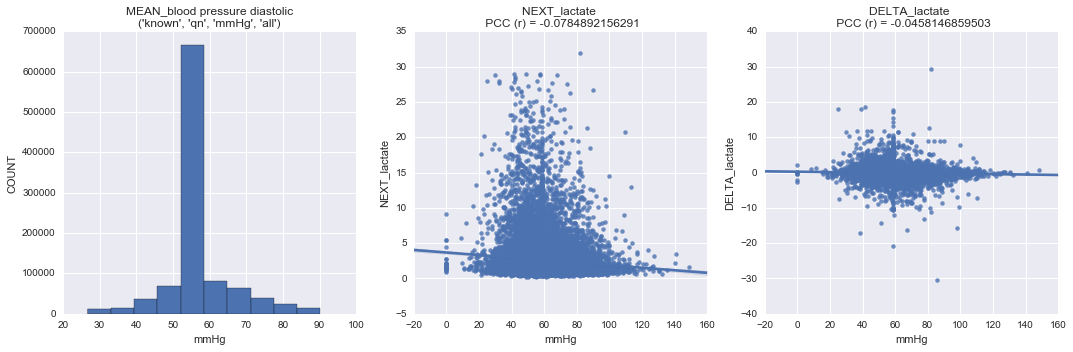

('MEAN', 'blood pressure diastolic', 'unknown', 'qn', 'cc/min', 'all')


MEAN
      blood pressure diastolic
                       unknown
                            qn
                        cc/min
                           all
count             1052741.0000
mean                   39.0700
std                     3.5102
min                     0.0000
25%                    39.0700
50%                    39.0700
75%                    39.0700
max                   555.0000

39.0699970003
MODE: 39.0699970003
896555
0.851638722155


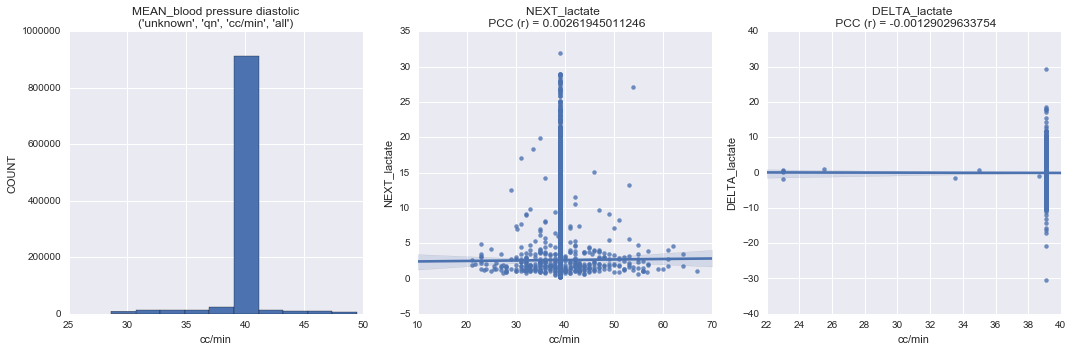

('MEAN', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all')


MEAN
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count        1052741.0000
mean              78.9112
std                6.3547
min                0.0000
25%               78.9112
50%               78.9112
75%               78.9112
max              348.6667

78.9112483349
MODE: 78.9112483349
879117
0.835074344022


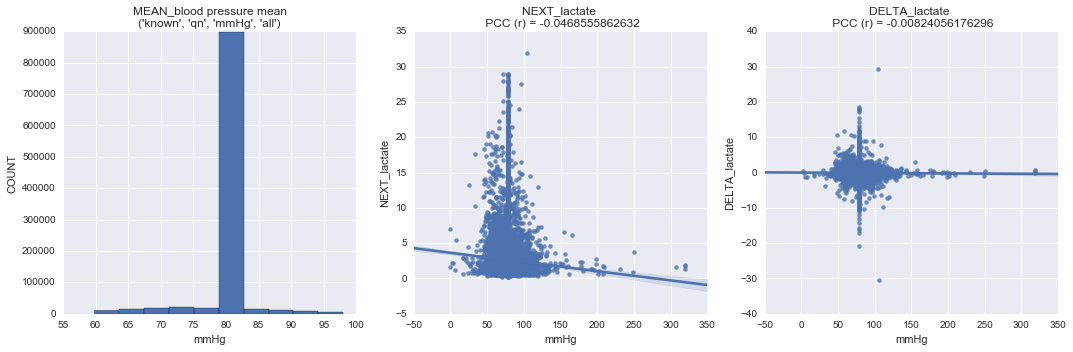

('MEAN', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all')


MEAN
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count            1052741.0000
mean                 122.1967
std                   14.1477
min                    0.0000
25%                  122.1967
50%                  122.1967
75%                  122.1967
max                  260.5000

122.196658598
MODE: 122.196658598
614924
0.584117081029


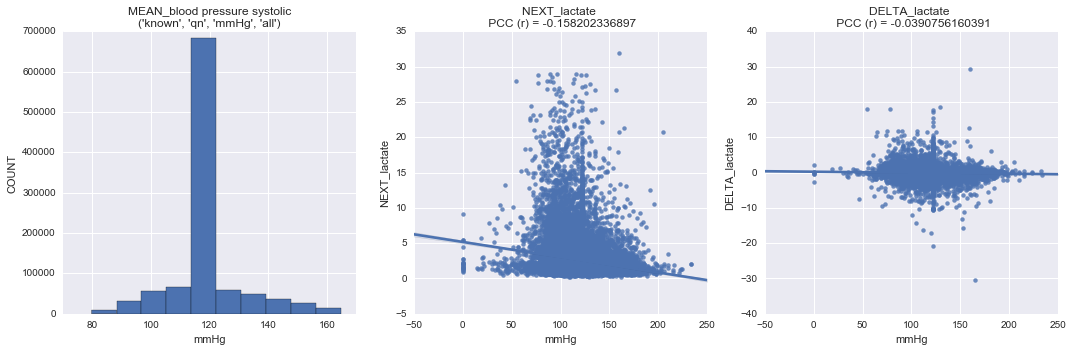

('MEAN', 'blood pressure systolic', 'unknown', 'qn', 'cc/min', 'all')


MEAN
      blood pressure systolic
                      unknown
                           qn
                       cc/min
                          all
count            1052741.0000
mean                  69.9656
std                    3.9351
min                    0.0000
25%                   69.9656
50%                   69.9656
75%                   69.9656
max                  136.0000

69.9655789769
MODE: 69.9655789769
896548
0.851632072846


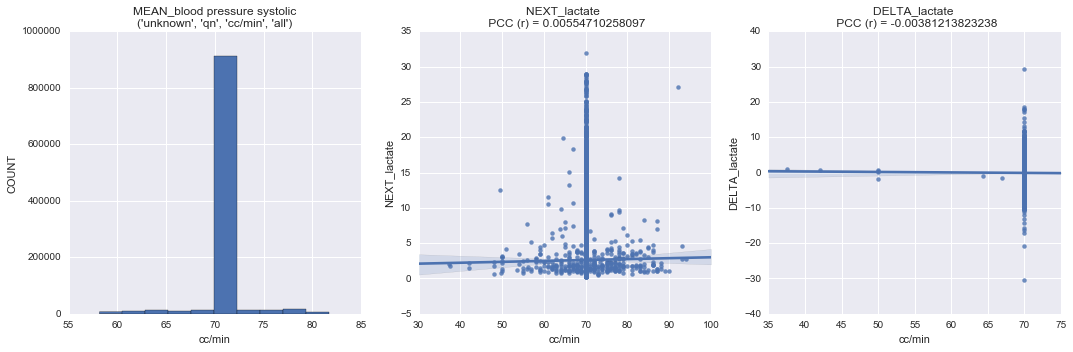

('MEAN', 'heart rate', 'known', 'qn', 'beats/min', 'all')


MEAN
         heart rate
              known
                 qn
          beats/min
                all
count  1052741.0000
mean       104.2830
std         25.9127
min          0.0000
25%         89.5000
50%        104.2830
75%        104.2830
max        232.7500

104.282969913
MODE: 104.282969913
458492
0.435522127475


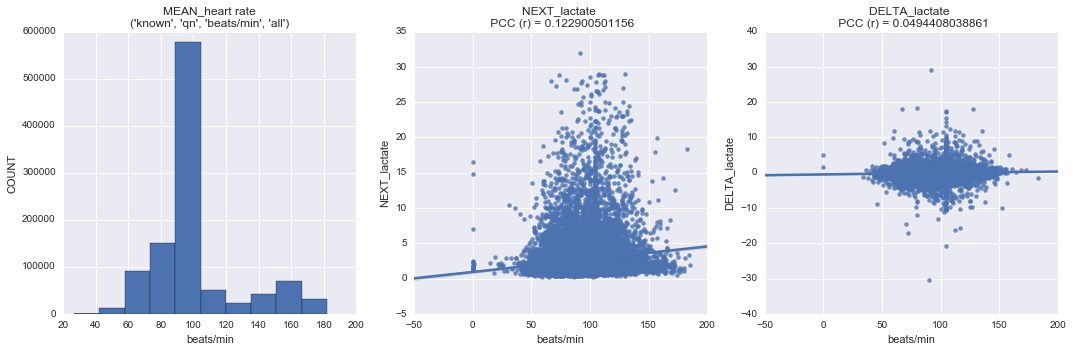

('MEAN', 'hemoglobin', 'known', 'qn', 'g/dL', 'all')


MEAN
         hemoglobin
              known
                 qn
               g/dL
                all
count  1052741.0000
mean        11.0976
std          1.9638
min          0.0000
25%         10.2000
50%         11.0976
75%         11.0976
max         32.6000

11.0975594886
MODE: 11.0975594886
447397
0.42498297302


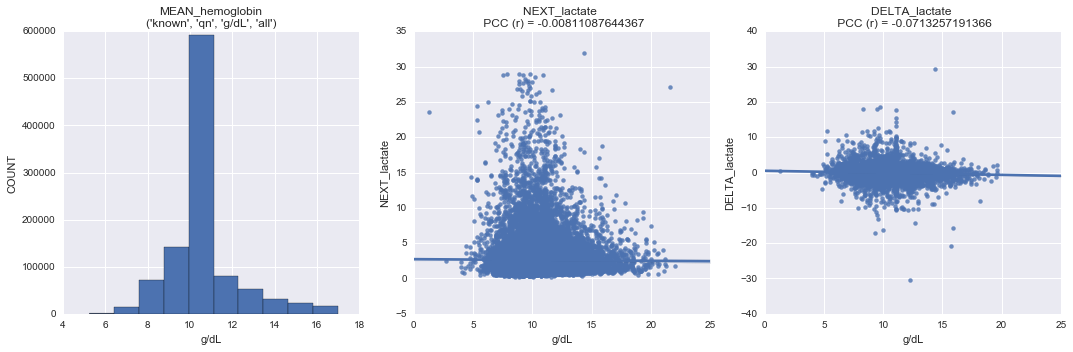

('MEAN', 'lactate', 'known', 'qn', 'mmol/L', 'all')


MEAN
            lactate
              known
                 qn
             mmol/L
                all
count  1052741.0000
mean         1.7800
std          0.8313
min          0.2000
25%          1.7800
50%          1.7800
75%          1.7800
max         32.0000

1.77995683493
MODE: 1.77995683493
692122
0.657447558326


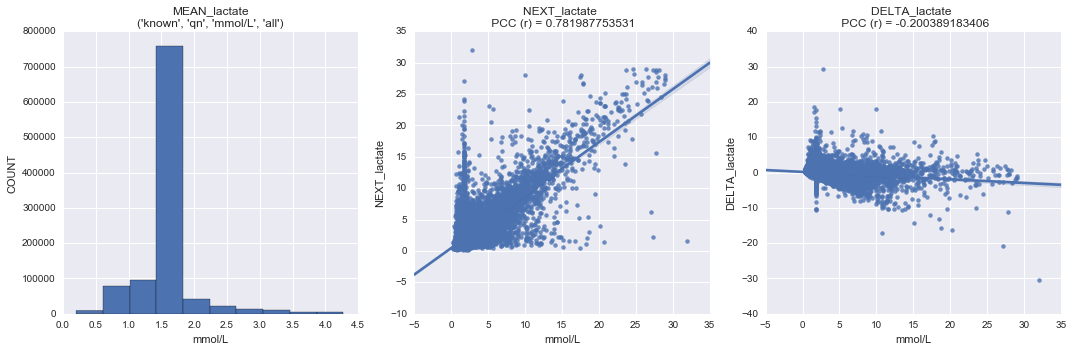

('MEAN', 'lactated ringers', 'known', 'qn', 'mL/hr', 'all')


MEAN
      lactated ringers
                 known
                    qn
                 mL/hr
                   all
count     1052741.0000
mean          277.2047
std            63.3540
min             0.0000
25%           277.2047
50%           277.2047
75%           277.2047
max          3113.5646

277.204656318
MODE: 277.204656318
1033970
0.982169403491


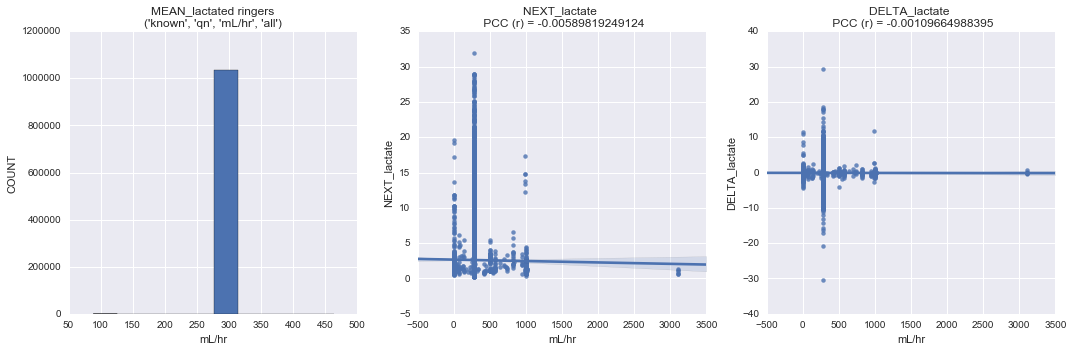

('MEAN', 'lactated ringers', 'unknown', 'qn', 'no_units', 'all')


MEAN
      lactated ringers
               unknown
                    qn
              no_units
                   all
count     1052741.0000
mean            0.0000
std             0.0000
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             0.0000

0.0
MODE: 0.0
1052741
1.0


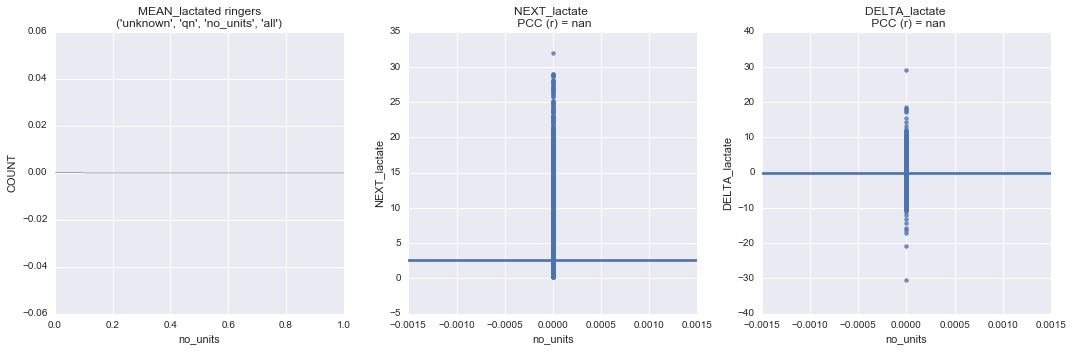

('MEAN', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all')


MEAN
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count   1052741.0000
mean          0.0486
std           0.0329
min           0.0000
25%           0.0486
50%           0.0486
75%           0.0486
max           4.0000

0.0485777099444
MODE: 0.0485777099444
984472
0.935151191034


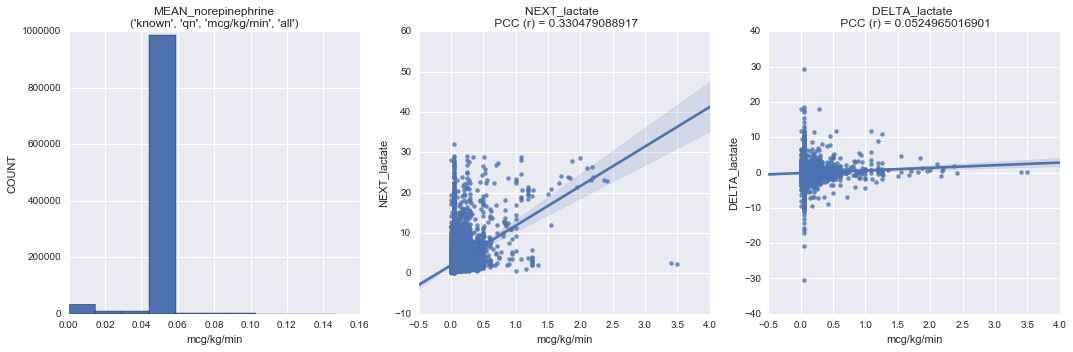

('MEAN', 'norepinephrine', 'known', 'qn', 'mcg/min', 'all')


MEAN
      norepinephrine
               known
                  qn
             mcg/min
                 all
count   1052741.0000
mean          5.3211
std           0.5730
min           0.0000
25%           5.3211
50%           5.3211
75%           5.3211
max          47.4667

5.32105103124
MODE: 5.32105103124
1048124
0.995614305893


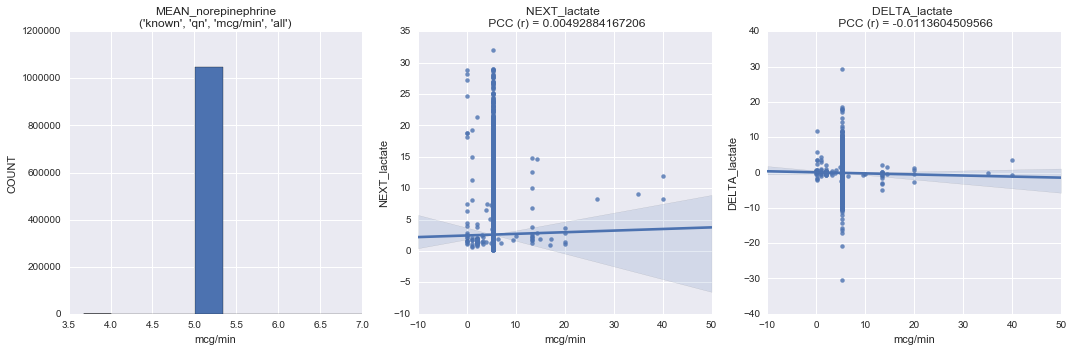

('MEAN', 'normal saline', 'known', 'qn', 'mL/hr', 'all')


MEAN
      normal saline
              known
                 qn
              mL/hr
                all
count  1052741.0000
mean       110.6007
std         79.6922
min          0.0509
25%        110.6007
50%        110.6007
75%        110.6007
max       3900.0000

110.600698868
MODE: 110.600698868
897517
0.852552527165


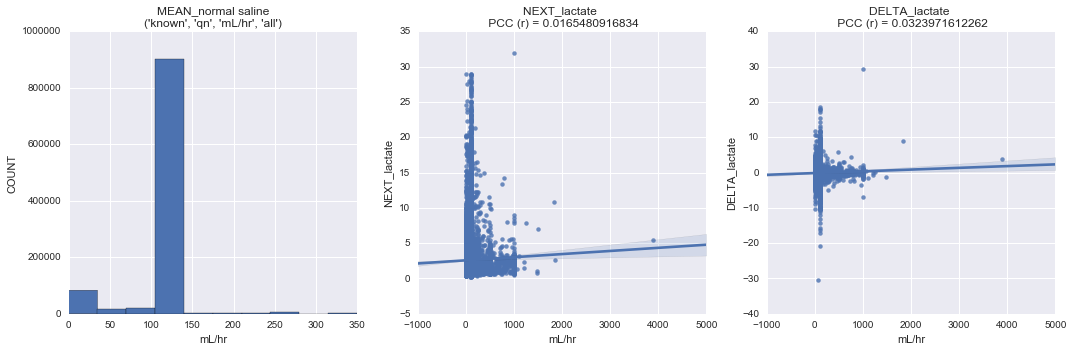

('MEAN', 'output urine', 'unknown', 'qn', 'no_units', 'all')


MEAN
       output urine
            unknown
                 qn
           no_units
                all
count  1052741.0000
mean         0.0000
std          0.0000
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          0.0000

0.0
MODE: 0.0
1052741
1.0


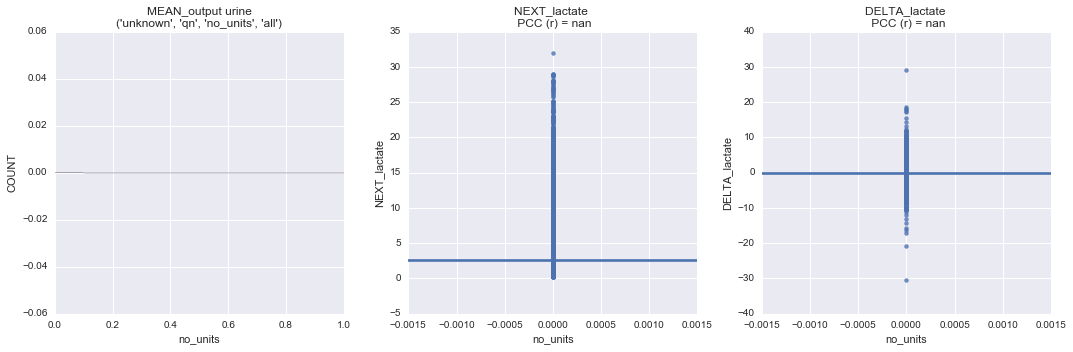

('MEAN', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all')


MEAN
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                     1052741.0000
mean                           97.0459
std                             2.1640
min                             0.0000
25%                            97.0459
50%                            97.0459
75%                            97.0459
max                           100.0000

97.0459308163
MODE: 97.0459308163
615156
0.584337458121


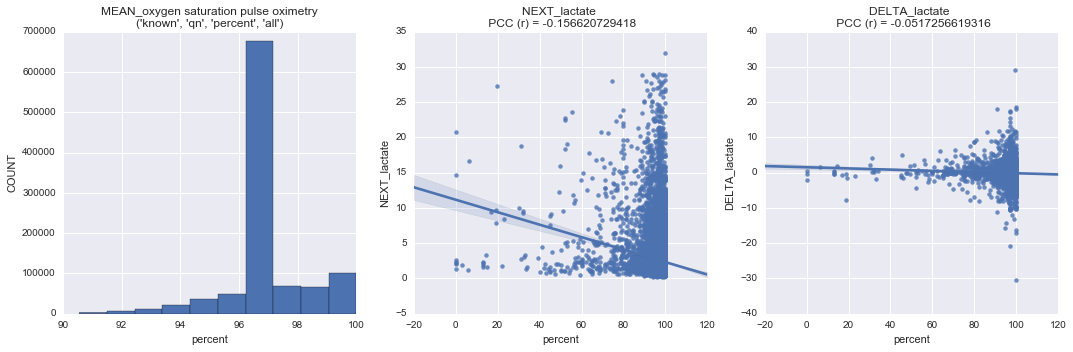

('MEAN', 'respiratory rate', 'known', 'qn', 'insp/min', 'all')


MEAN
      respiratory rate
                 known
                    qn
              insp/min
                   all
count     1052741.0000
mean           20.1902
std             3.6626
min             0.0000
25%            20.1902
50%            20.1902
75%            20.1902
max           102.0000

20.1902496239
MODE: 20.1902496239
615315
0.584488492421


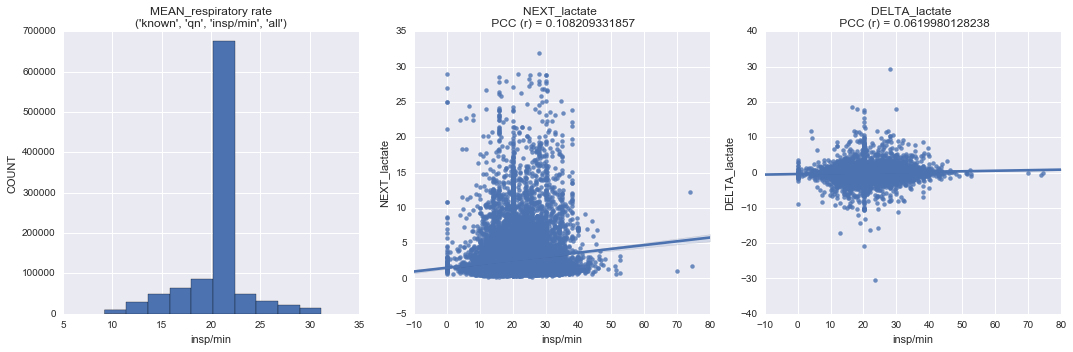

('MEAN', 'respiratory rate', 'unknown', 'qn', 'Breath', 'all')


MEAN
      respiratory rate
               unknown
                    qn
                Breath
                   all
count     1052741.0000
mean           49.2991
std             4.3529
min             0.0000
25%            49.2991
50%            49.2991
75%            49.2991
max           120.0000

49.2990696074
MODE: 49.2990696074
896665
0.851743211293


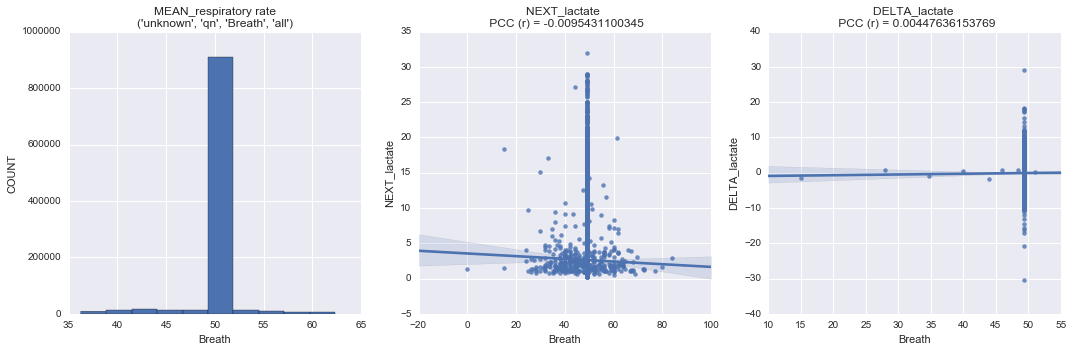

('MEAN', 'temperature body', 'known', 'qn', 'degF', 'all')


MEAN
      temperature body
                 known
                    qn
                  degF
                   all
count     1052741.0000
mean           98.4286
std             1.3685
min             0.0000
25%            98.4286
50%            98.4286
75%            98.4286
max           106.8000

98.4286195962
MODE: 98.4286195962
618632
0.587639314893


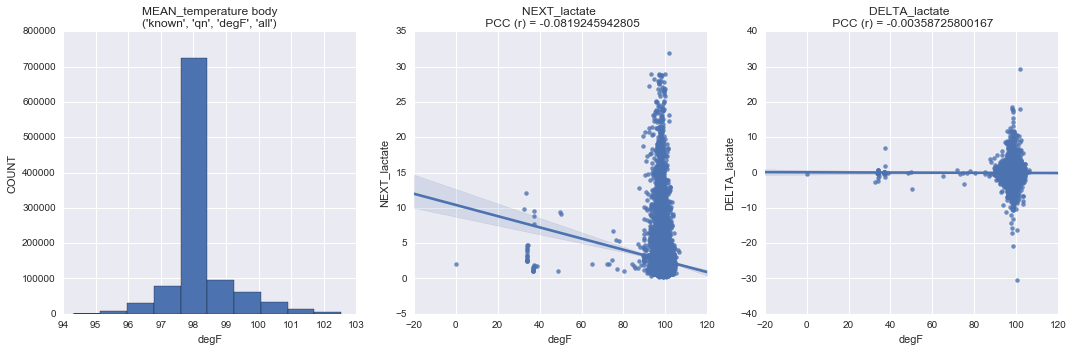

('MEAN', 'vasopressin', 'known', 'qn', 'units', 'all')


MEAN
        vasopressin
              known
                 qn
              units
                all
count  1052741.0000
mean         1.0848
std          0.5747
min          0.0000
25%          1.0848
50%          1.0848
75%          1.0848
max        264.0000

1.08480708891
MODE: 1.08480708891
1034476
0.982650053527


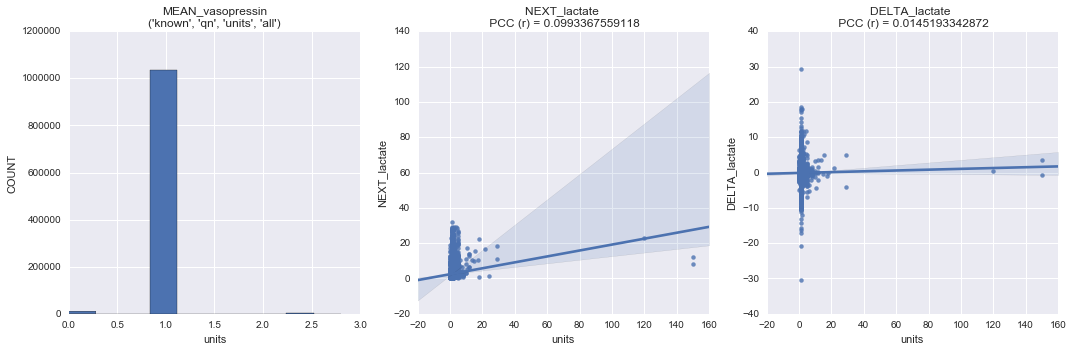

('MEAN', 'vasopressin', 'known', 'qn', 'units/min', 'all')


MEAN
        vasopressin
              known
                 qn
          units/min
                all
count  1052741.0000
mean         0.4456
std          0.1479
min          0.0000
25%          0.4456
50%          0.4456
75%          0.4456
max          5.0000

0.445627214239
MODE: 0.445627214239
1018287
0.967272102065


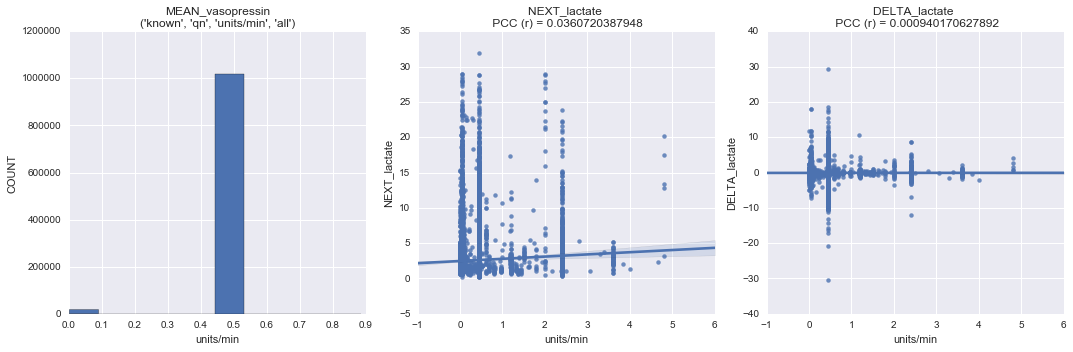

('MEAN', 'weight body', 'known', 'qn', 'kg', 'all')


MEAN
        weight body
              known
                 qn
                 kg
                all
count  1052741.0000
mean        82.7296
std         15.7339
min          0.0000
25%         82.7296
50%         82.7296
75%         82.7296
max        277.4000

82.7295531383
MODE: 82.7295531383
739616
0.702562168663


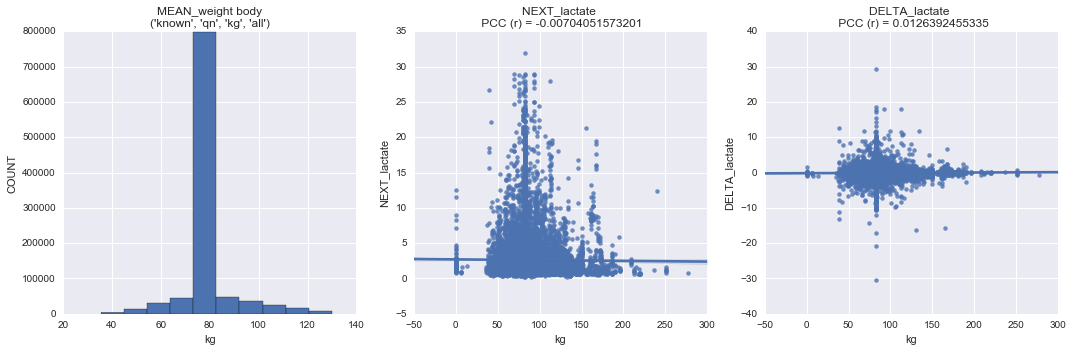

('LAST', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all')


LAST
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count             1052741.0000
mean                   58.3430
std                    11.1625
min                     0.0000
25%                    58.3430
50%                    58.3430
75%                    58.3430
max                   445.0000

58.3430281918
MODE: 58.3430281918
581292
0.552170001928


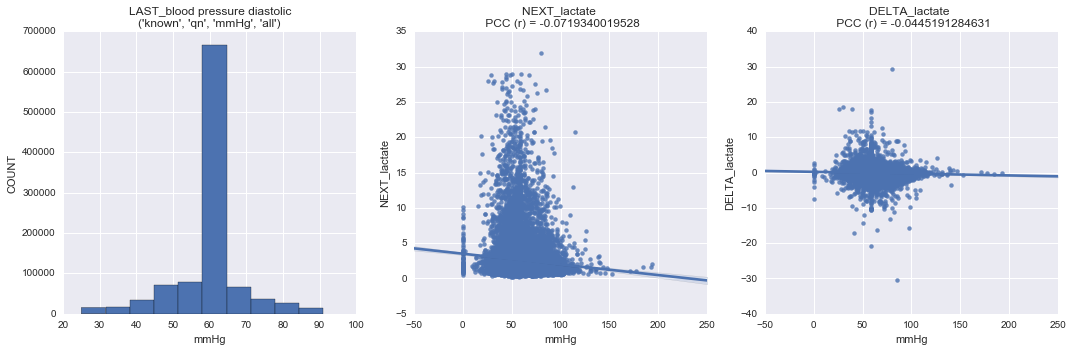

('LAST', 'blood pressure diastolic', 'unknown', 'qn', 'cc/min', 'all')


LAST
      blood pressure diastolic
                       unknown
                            qn
                        cc/min
                           all
count             1052741.0000
mean                   39.0729
std                     3.5375
min                     0.0000
25%                    39.0729
50%                    39.0729
75%                    39.0729
max                   555.0000

39.0729007722
MODE: 39.0729007722
896555
0.851638722155


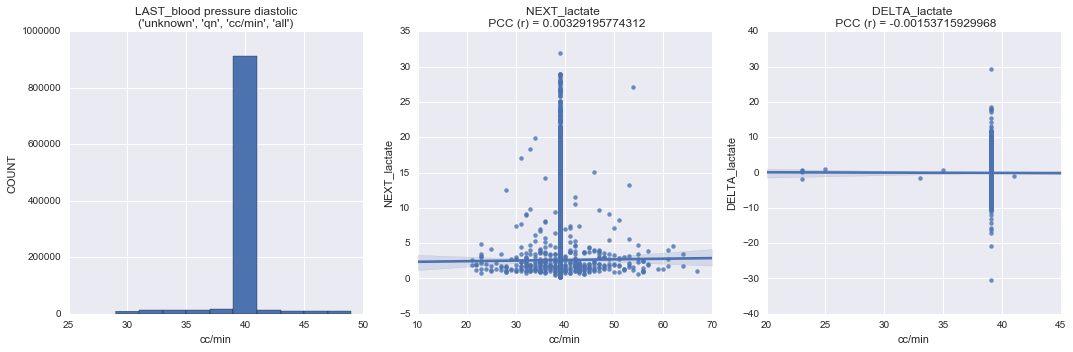

('LAST', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all')


LAST
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count        1052741.0000
mean              78.6461
std                6.9922
min                0.0000
25%               78.6461
50%               78.6461
75%               78.6461
max              361.0000

78.6461318712
MODE: 78.6461318712
879117
0.835074344022


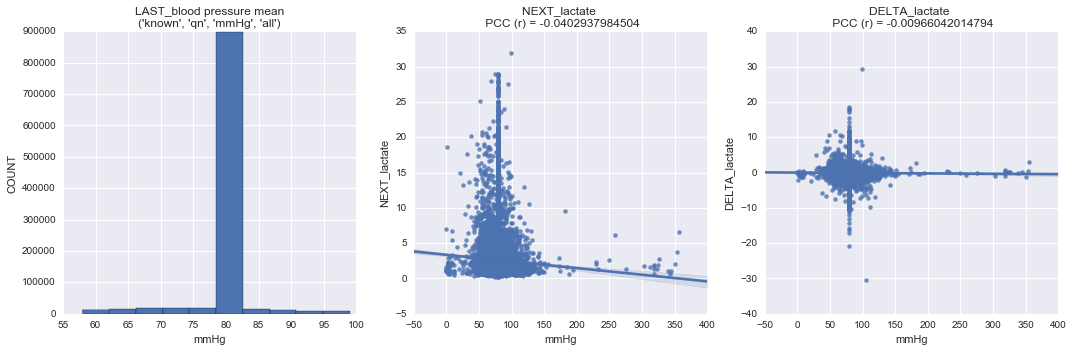

('LAST', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all')


LAST
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count            1052741.0000
mean                 122.0023
std                   15.0349
min                    0.0000
25%                  122.0023
50%                  122.0023
75%                  122.0023
max                  294.0000

122.002258021
MODE: 122.002258021
614924
0.584117081029


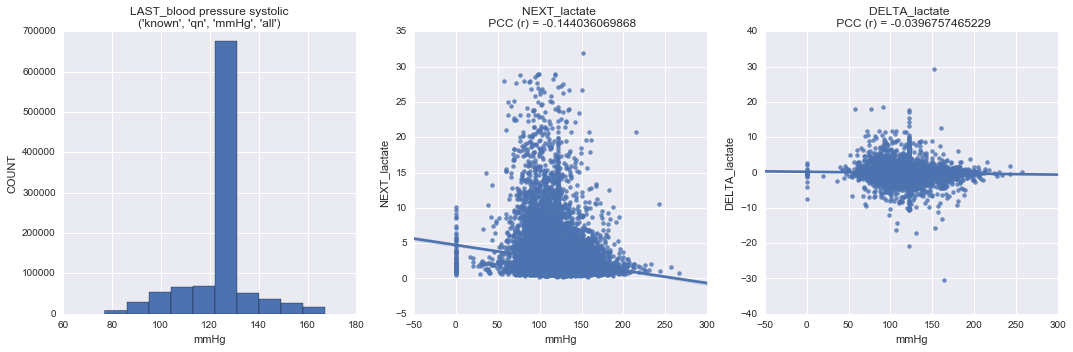

('LAST', 'blood pressure systolic', 'unknown', 'qn', 'cc/min', 'all')


LAST
      blood pressure systolic
                      unknown
                           qn
                       cc/min
                          all
count            1052741.0000
mean                  69.9751
std                    3.9663
min                    0.0000
25%                   69.9751
50%                   69.9751
75%                   69.9751
max                  136.0000

69.975139731
MODE: 69.975139731
896548
0.851632072846


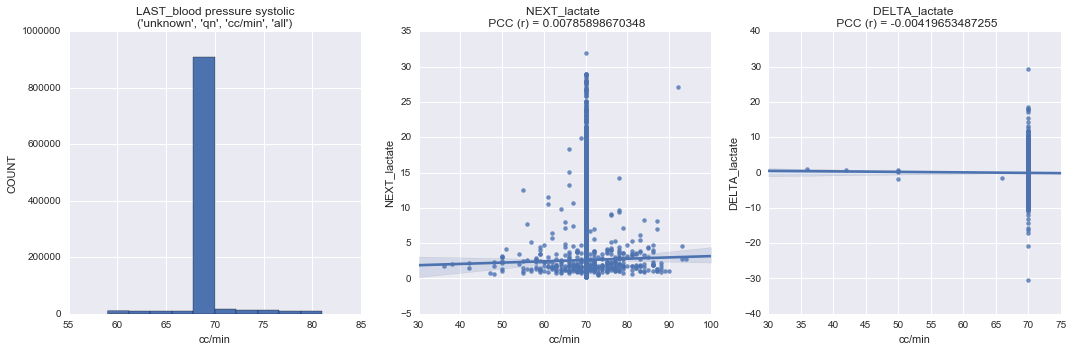

('LAST', 'heart rate', 'known', 'qn', 'beats/min', 'all')


LAST
         heart rate
              known
                 qn
          beats/min
                all
count  1052741.0000
mean       104.1569
std         26.2094
min          0.0000
25%         89.0000
50%        104.1569
75%        104.1569
max        250.0000

104.156927635
MODE: 104.156927635
458492
0.435522127475


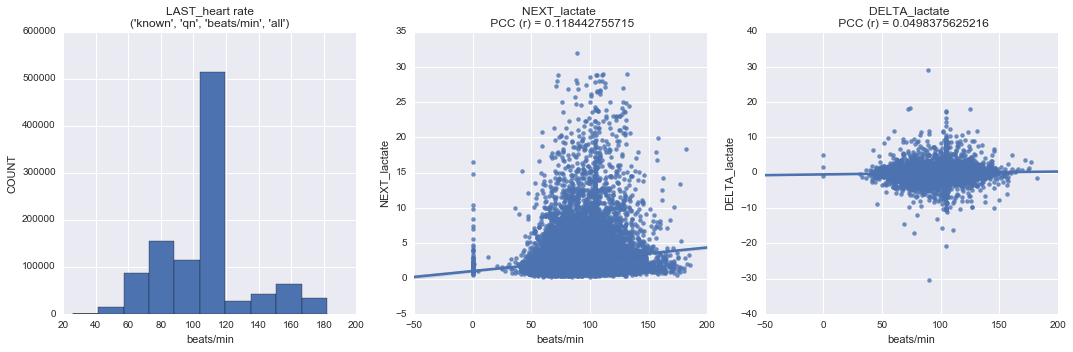

('LAST', 'hemoglobin', 'known', 'qn', 'g/dL', 'all')


LAST
         hemoglobin
              known
                 qn
               g/dL
                all
count  1052741.0000
mean        11.0938
std          1.9647
min          0.0000
25%         10.2000
50%         11.0938
75%         11.0938
max         32.6000

11.0938443437
MODE: 11.0938443437
447397
0.42498297302


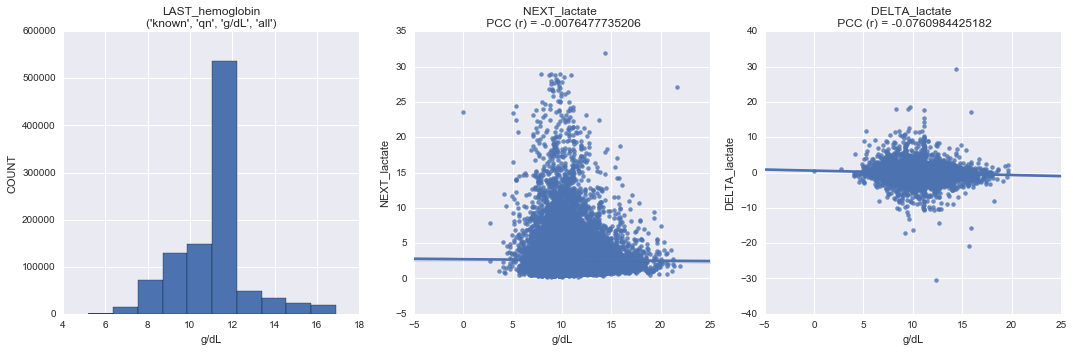

('LAST', 'lactate', 'known', 'qn', 'mmol/L', 'all')


LAST
            lactate
              known
                 qn
             mmol/L
                all
count  1052741.0000
mean         1.7765
std          0.8350
min          0.2000
25%          1.7765
50%          1.7765
75%          1.7765
max         32.0000

1.77648215984
MODE: 1.77648215984
692122
0.657447558326


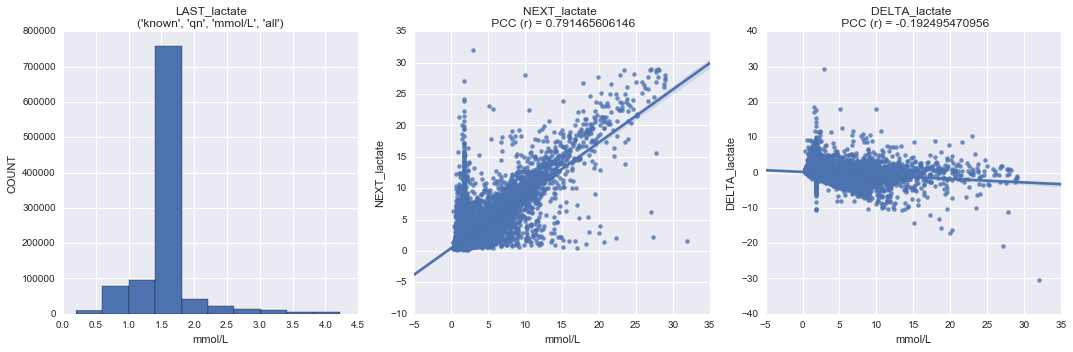

('LAST', 'lactated ringers', 'known', 'qn', 'mL/hr', 'all')


LAST
      lactated ringers
                 known
                    qn
                 mL/hr
                   all
count     1052741.0000
mean          278.4063
std            63.5447
min             0.0000
25%           278.4063
50%           278.4063
75%           278.4063
max          3113.5646

278.40625949
MODE: 278.40625949
1033970
0.982169403491


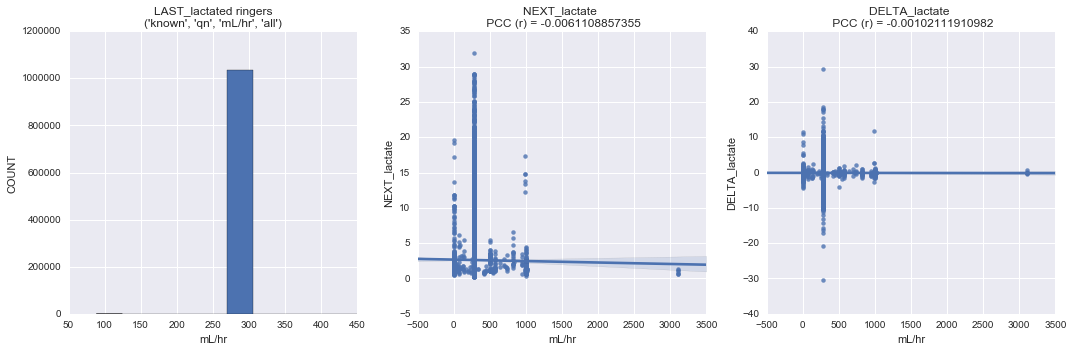

('LAST', 'lactated ringers', 'unknown', 'qn', 'no_units', 'all')


LAST
      lactated ringers
               unknown
                    qn
              no_units
                   all
count     1052741.0000
mean            0.0000
std             0.0000
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             0.0000

0.0
MODE: 0.0
1052741
1.0


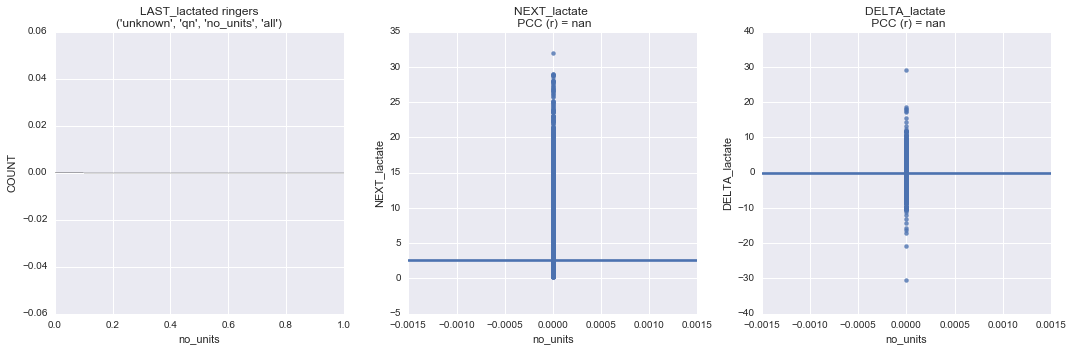

('LAST', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all')


LAST
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count   1052741.0000
mean          0.0486
std           0.0333
min           0.0000
25%           0.0486
50%           0.0486
75%           0.0486
max           4.0000

0.0485749191096
MODE: 0.0485749191096
984472
0.935151191034


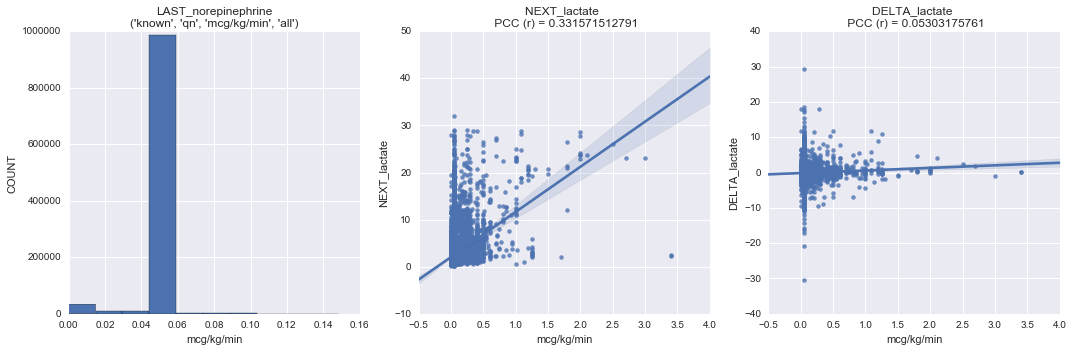

('LAST', 'norepinephrine', 'known', 'qn', 'mcg/min', 'all')


LAST
      norepinephrine
               known
                  qn
             mcg/min
                 all
count   1052741.0000
mean          5.3236
std           0.5746
min           0.0000
25%           5.3236
50%           5.3236
75%           5.3236
max          46.9333

5.32355490762
MODE: 5.32355490762
1048124
0.995614305893


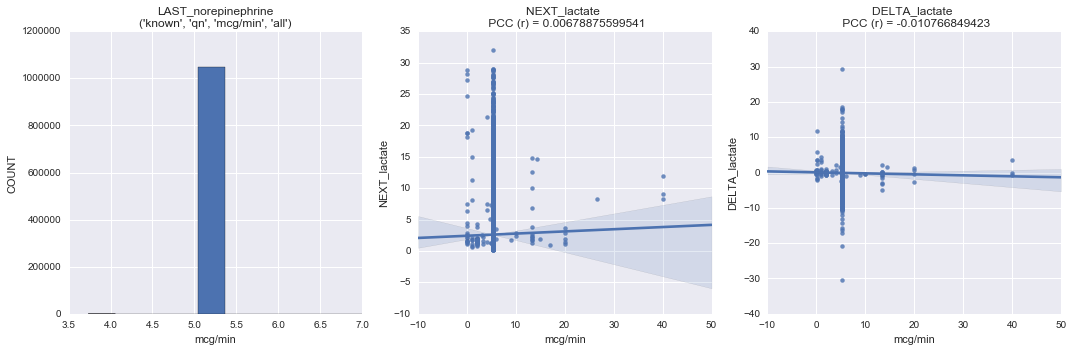

('LAST', 'normal saline', 'known', 'qn', 'mL/hr', 'all')


LAST
      normal saline
              known
                 qn
              mL/hr
                all
count  1052741.0000
mean       111.6814
std         82.4123
min          0.0167
25%        111.6814
50%        111.6814
75%        111.6814
max       3900.0000

111.681415157
MODE: 111.681415157
897517
0.852552527165


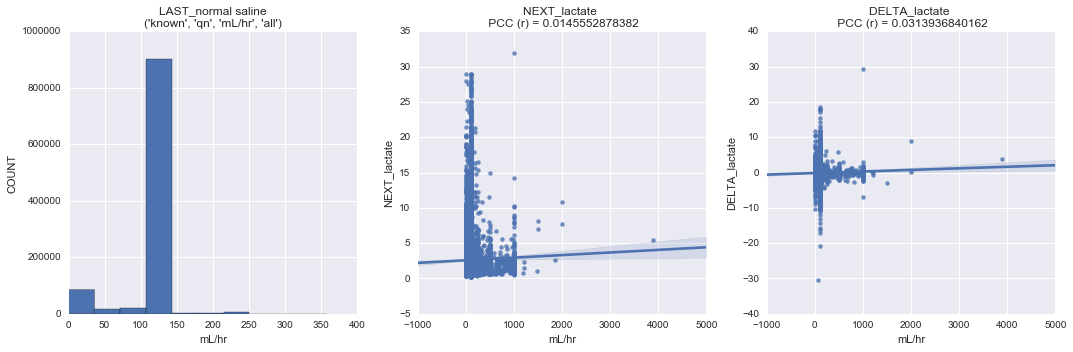

('LAST', 'output urine', 'unknown', 'qn', 'no_units', 'all')


LAST
       output urine
            unknown
                 qn
           no_units
                all
count  1052741.0000
mean         0.0000
std          0.0000
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          0.0000

0.0
MODE: 0.0
1052741
1.0


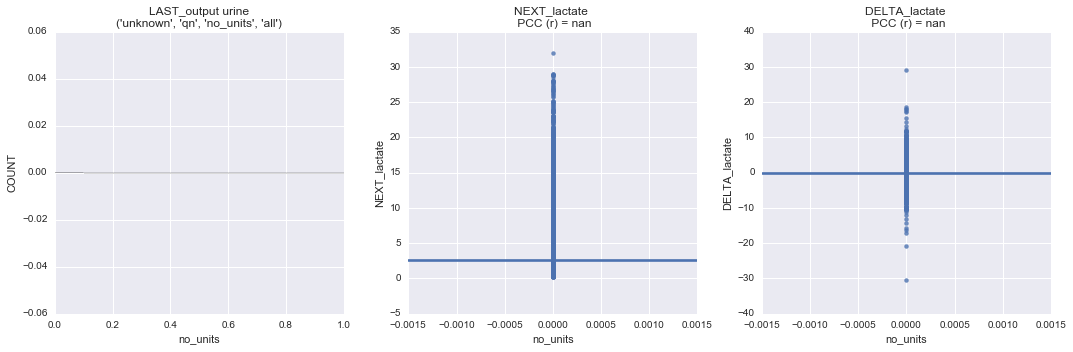

('LAST', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all')


LAST
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                     1052741.0000
mean                           97.0154
std                             2.4417
min                             0.0000
25%                            97.0154
50%                            97.0154
75%                            97.0154
max                           100.0000

97.0153723277
MODE: 97.0153723277
615156
0.584337458121


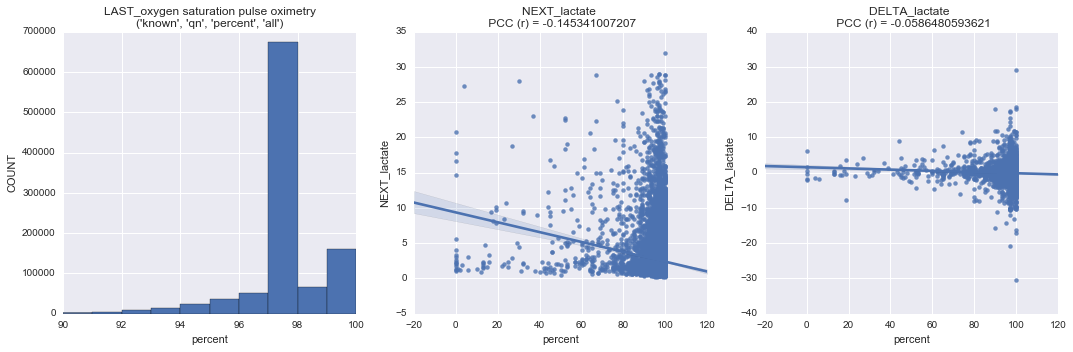

('LAST', 'respiratory rate', 'known', 'qn', 'insp/min', 'all')


LAST
      respiratory rate
                 known
                    qn
              insp/min
                   all
count     1052741.0000
mean           20.1585
std             3.9791
min             0.0000
25%            20.1585
50%            20.1585
75%            20.1585
max           114.0000

20.158506856
MODE: 20.158506856
615315
0.584488492421


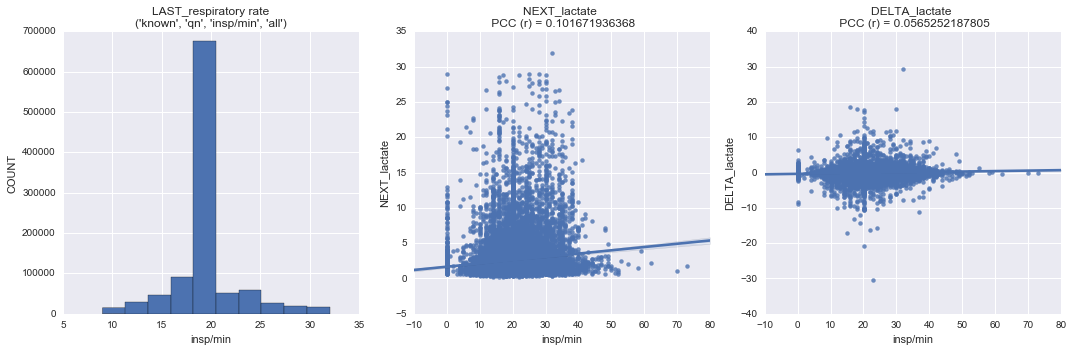

('LAST', 'respiratory rate', 'unknown', 'qn', 'Breath', 'all')


LAST
      respiratory rate
               unknown
                    qn
                Breath
                   all
count     1052741.0000
mean           49.3268
std             5.1703
min             0.0000
25%            49.3268
50%            49.3268
75%            49.3268
max           126.0000

49.3268279556
MODE: 49.3268279556
896665
0.851743211293


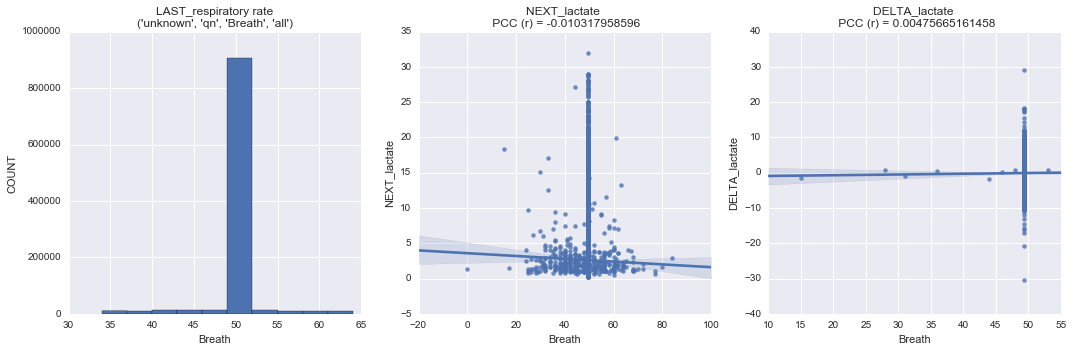

('LAST', 'temperature body', 'known', 'qn', 'degF', 'all')


LAST
      temperature body
                 known
                    qn
                  degF
                   all
count     1052741.0000
mean           98.4297
std             1.4365
min             0.0000
25%            98.4297
50%            98.4297
75%            98.4297
max           107.0000

98.4297160285
MODE: 98.4297160285
618632
0.587639314893


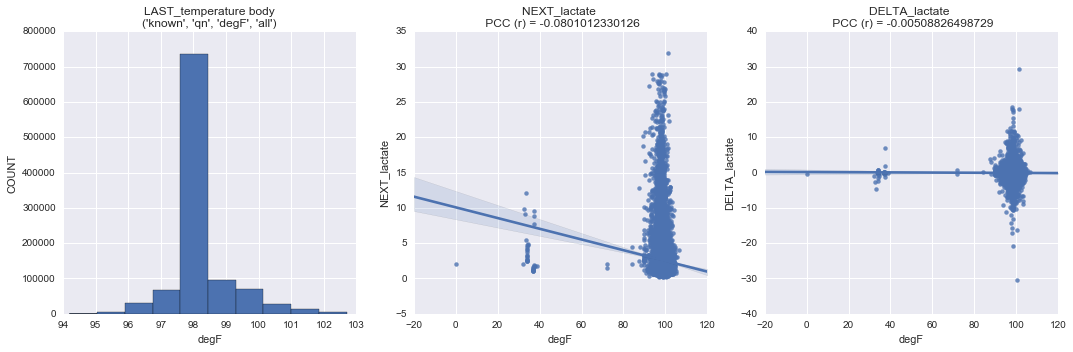

('LAST', 'vasopressin', 'known', 'qn', 'units', 'all')


LAST
        vasopressin
              known
                 qn
              units
                all
count  1052741.0000
mean         1.0810
std          0.6325
min          0.0000
25%          1.0810
50%          1.0810
75%          1.0810
max        264.0000

1.08103382192
MODE: 1.08103382192
1034476
0.982650053527


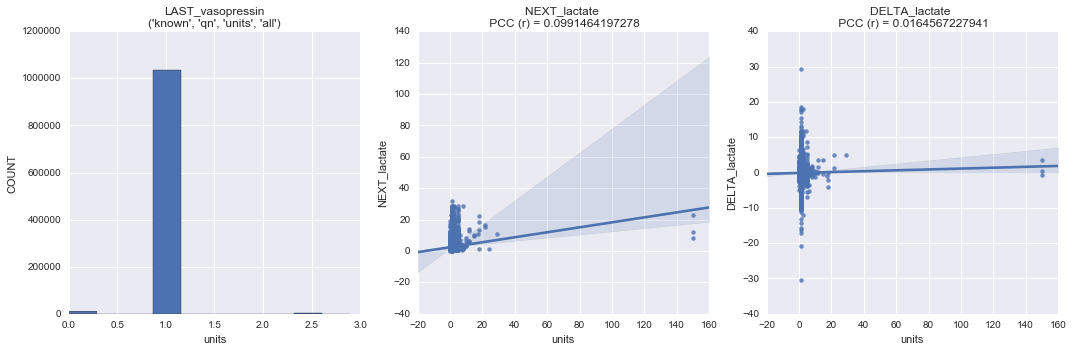

('LAST', 'vasopressin', 'known', 'qn', 'units/min', 'all')


LAST
        vasopressin
              known
                 qn
          units/min
                all
count  1052741.0000
mean         0.4458
std          0.1480
min          0.0000
25%          0.4458
50%          0.4458
75%          0.4458
max          5.0000

0.445797182988
MODE: 0.445797182988
1018287
0.967272102065


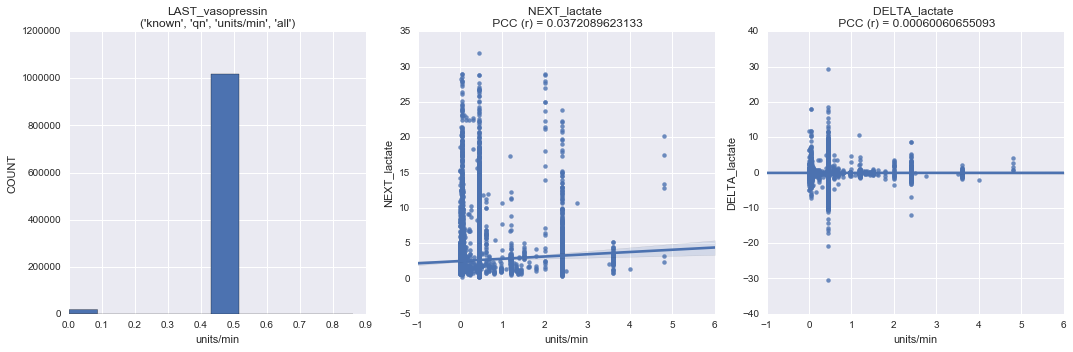

('LAST', 'weight body', 'known', 'qn', 'kg', 'all')


LAST
        weight body
              known
                 qn
                 kg
                all
count  1052741.0000
mean        82.7292
std         15.7363
min          0.0000
25%         82.7292
50%         82.7292
75%         82.7292
max        277.4000

82.7291790095
MODE: 82.7291790095
739616
0.702562168663


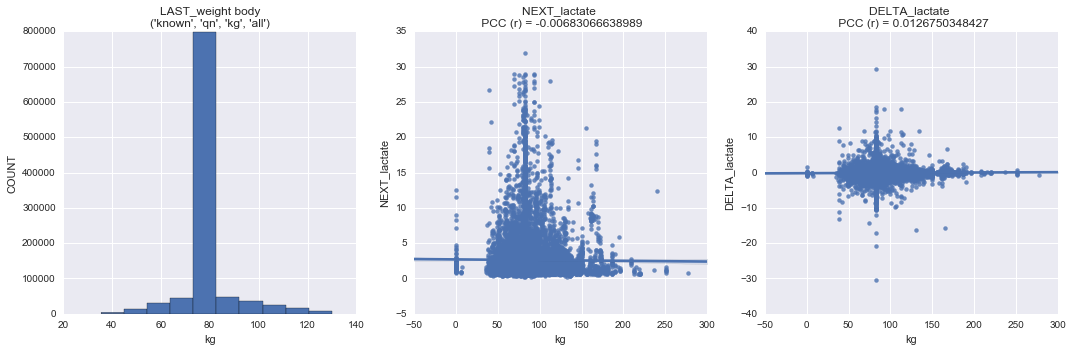

('STD', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all')


STD
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count             1052741.0000
mean                    1.8779
std                     4.4516
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     2.0817
max                   284.2569

0.0
MODE: 0.0
714326
0.678539165854


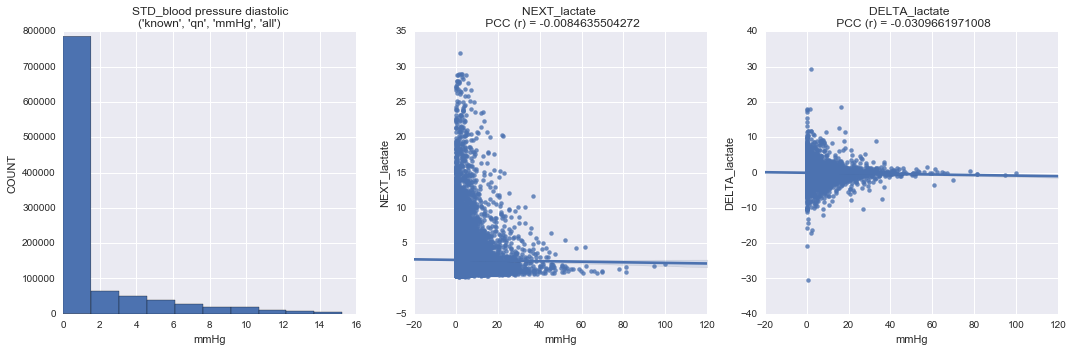

('STD', 'blood pressure diastolic', 'unknown', 'qn', 'cc/min', 'all')


STD
      blood pressure diastolic
                       unknown
                            qn
                        cc/min
                           all
count             1052741.0000
mean                    0.0143
std                     0.5128
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     0.0000
max                   349.3026

0.0
MODE: 0.0
1049992
0.997388721442


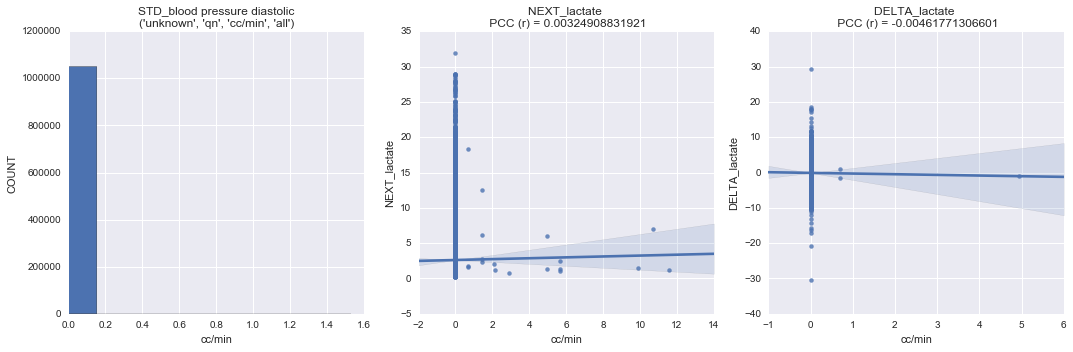

('STD', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all')


STD
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count        1052741.0000
mean               0.9192
std                4.1453
min                0.0000
25%                0.0000
50%                0.0000
75%                0.0000
max              211.4249

0.0
MODE: 0.0
912312
0.866606316273


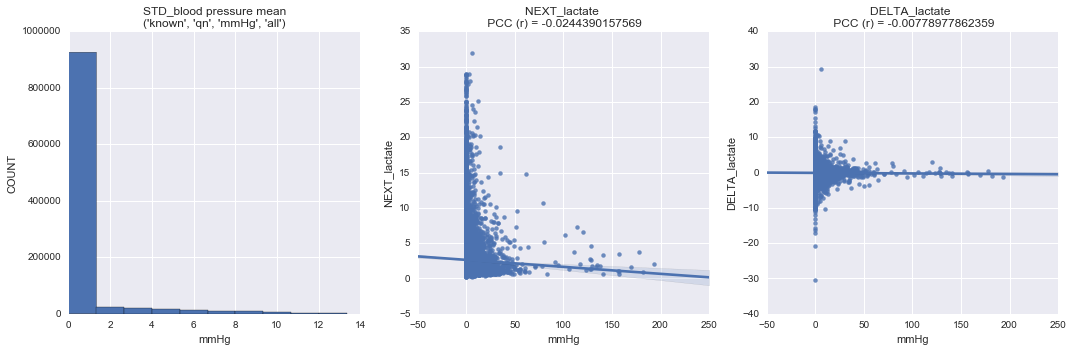

('STD', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all')


STD
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count            1052741.0000
mean                   2.8765
std                    6.3305
min                    0.0000
25%                    0.0000
50%                    0.0000
75%                    2.8284
max                  185.9691

0.0
MODE: 0.0
706896
0.671481399509


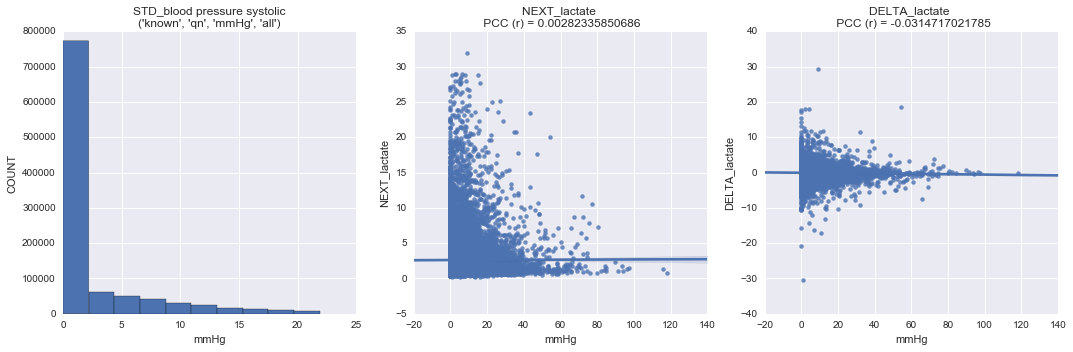

('STD', 'blood pressure systolic', 'unknown', 'qn', 'cc/min', 'all')


STD
      blood pressure systolic
                      unknown
                           qn
                       cc/min
                          all
count            1052741.0000
mean                   0.0133
std                    0.3384
min                    0.0000
25%                    0.0000
50%                    0.0000
75%                    0.0000
max                   61.5183

0.0
MODE: 0.0
1049983
0.997380172331


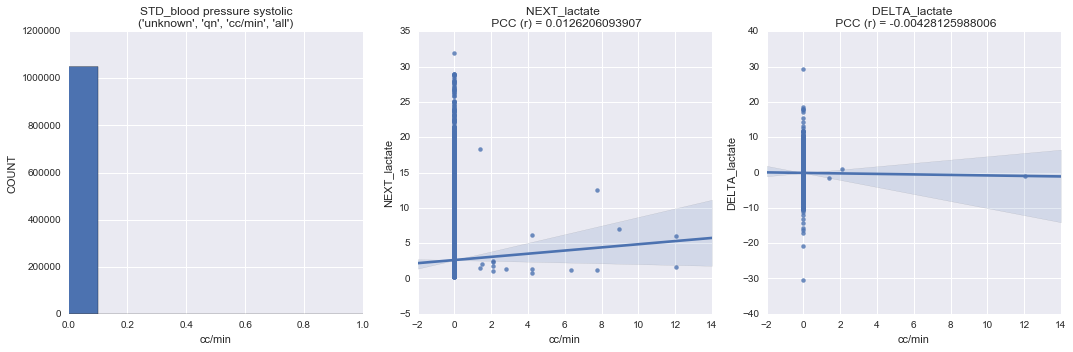

('STD', 'glasgow coma scale eye opening', 'known', 'ord', 'no_units', 'all')


STD
      glasgow coma scale eye opening
                               known
                                 ord
                            no_units
                                 all
count                   1052741.0000
mean                          0.0015
std                           0.0423
min                           0.0000
25%                           0.0000
50%                           0.0000
75%                           0.0000
max                           2.1213

0.0
MODE: 0.0
1051118
0.998458310259


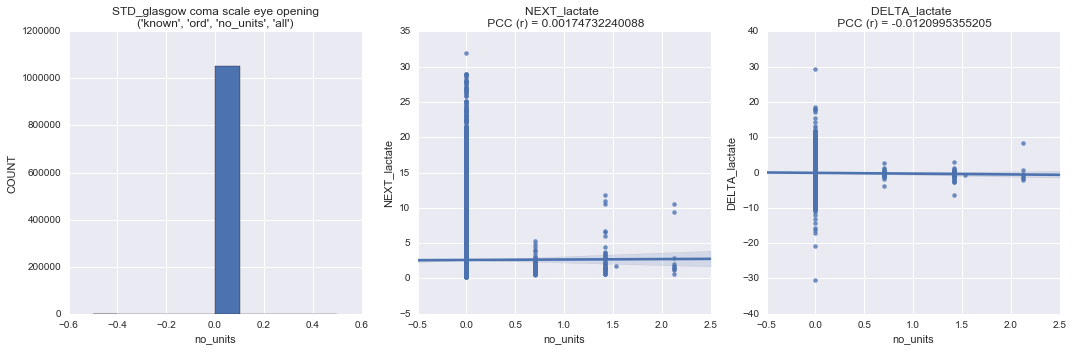

('STD', 'glasgow coma scale motor', 'known', 'ord', 'no_units', 'all')


STD
      glasgow coma scale motor
                         known
                           ord
                      no_units
                           all
count             1052741.0000
mean                    0.0015
std                     0.0576
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     0.0000
max                     3.5355

0.0
MODE: 0.0
1051695
0.999006403284


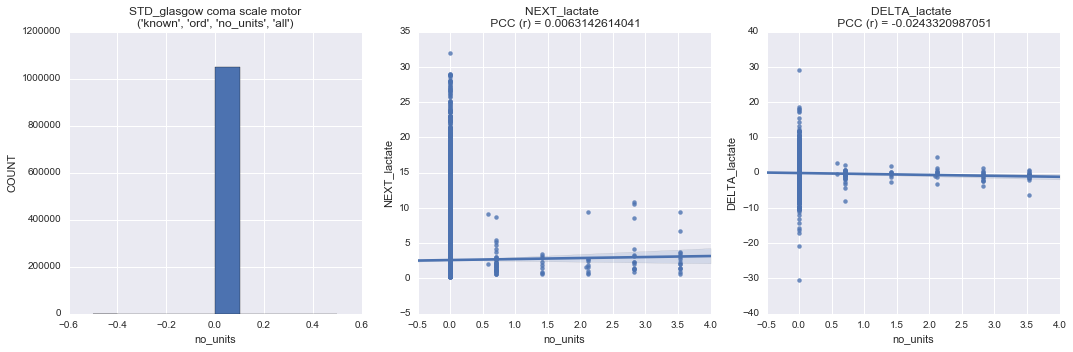

('STD', 'glasgow coma scale verbal', 'known', 'ord', 'no_units', 'all')


STD
      glasgow coma scale verbal
                          known
                            ord
                       no_units
                            all
count              1052741.0000
mean                     0.0008
std                      0.0395
min                      0.0000
25%                      0.0000
50%                      0.0000
75%                      0.0000
max                      2.8284

0.0
MODE: 0.0
1052171
0.999458556283


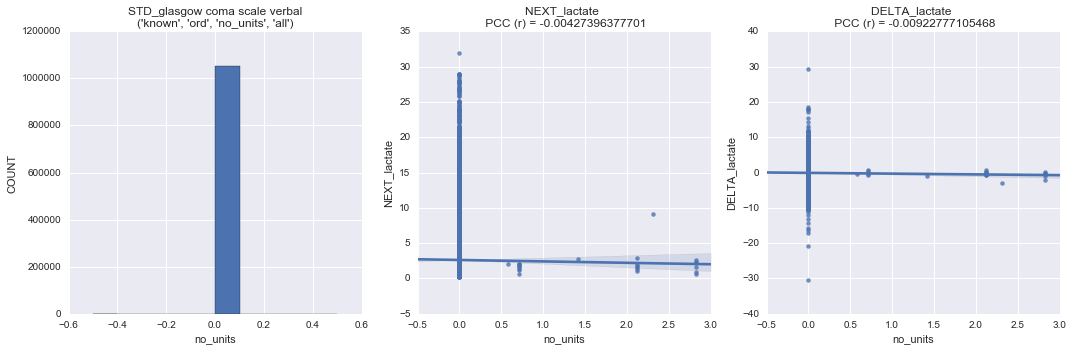

('STD', 'heart rate', 'known', 'qn', 'beats/min', 'all')


STD
         heart rate
              known
                 qn
          beats/min
                all
count  1052741.0000
mean         2.3373
std          4.4076
min          0.0000
25%          0.0000
50%          0.0000
75%          2.8284
max        126.5721

0.0
MODE: 0.0
577121
0.548207963782


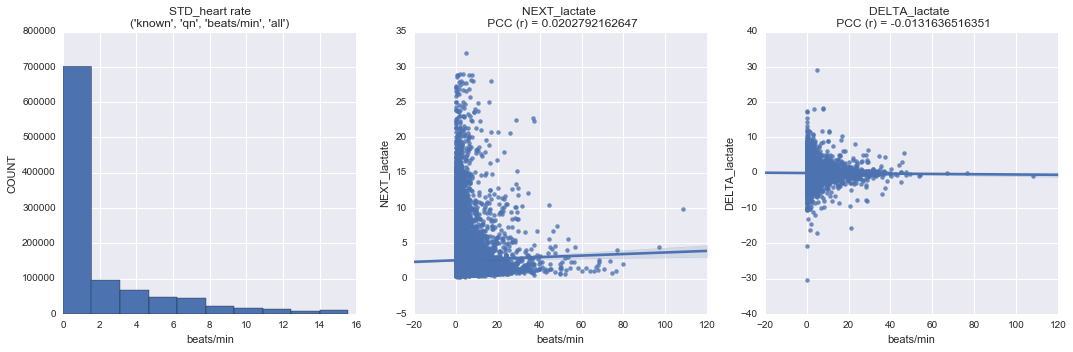

('STD', 'hemoglobin', 'known', 'qn', 'g/dL', 'all')


STD
         hemoglobin
              known
                 qn
               g/dL
                all
count  1052741.0000
mean         0.0030
std          0.0661
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max         11.4614

0.0
MODE: 0.0
1047887
0.995389179295


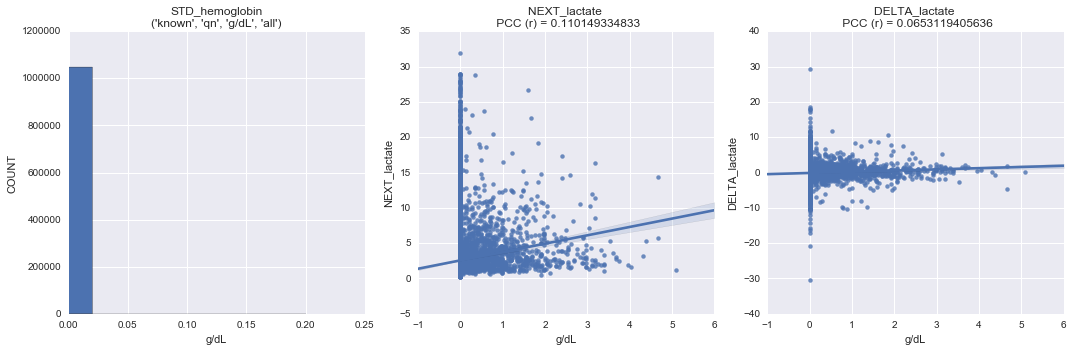

('STD', 'lactate', 'known', 'qn', 'mmol/L', 'all')


STD
            lactate
              known
                 qn
             mmol/L
                all
count  1052741.0000
mean         0.0010
std          0.0378
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          7.6368

0.0
MODE: 0.0
1050915
0.998265480303


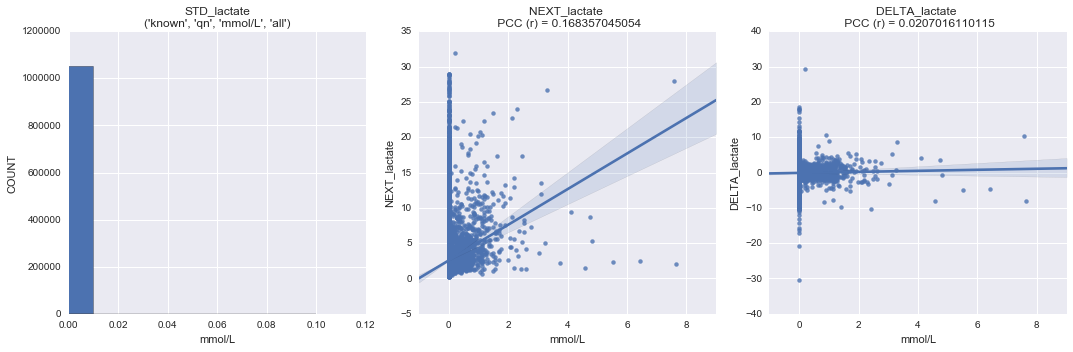

('STD', 'lactated ringers', 'known', 'qn', 'mL', 'all')


STD
      lactated ringers
                 known
                    qn
                    mL
                   all
count     1052741.0000
mean            0.5443
std            15.5020
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max          3585.1546

0.0
MODE: 0.0
1048949
0.996397974431


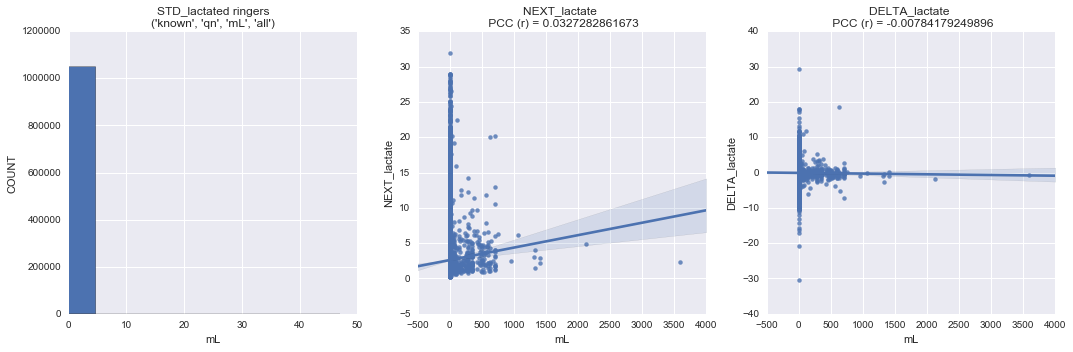

('STD', 'lactated ringers', 'known', 'qn', 'mL/hr', 'all')


STD
      lactated ringers
                 known
                    qn
                 mL/hr
                   all
count     1052741.0000
mean            0.0024
std             1.2162
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max          1060.6601

0.0
MODE: 0.0
1052727
0.999986701382


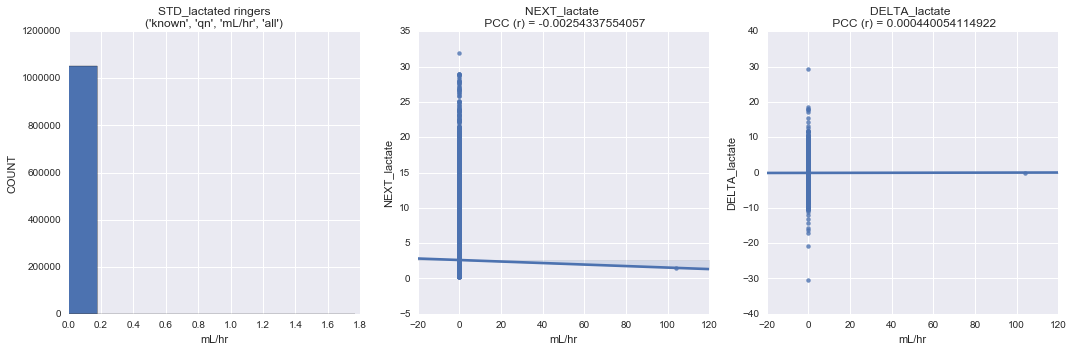

('STD', 'lactated ringers', 'unknown', 'qn', 'no_units', 'all')


STD
      lactated ringers
               unknown
                    qn
              no_units
                   all
count     1052741.0000
mean            0.0000
std             0.0000
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             0.0000

0.0
MODE: 0.0
1052741
1.0


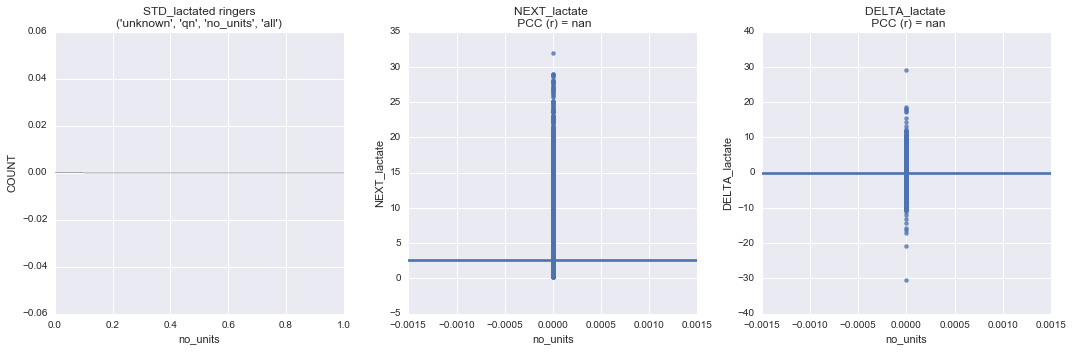

('STD', 'norepinephrine', 'known', 'qn', 'mcg', 'all')


STD
      norepinephrine
               known
                  qn
                 mcg
                 all
count   1052741.0000
mean          1.5904
std          57.1678
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max       29398.6715

0.0
MODE: 0.0
1043892
0.99159432377


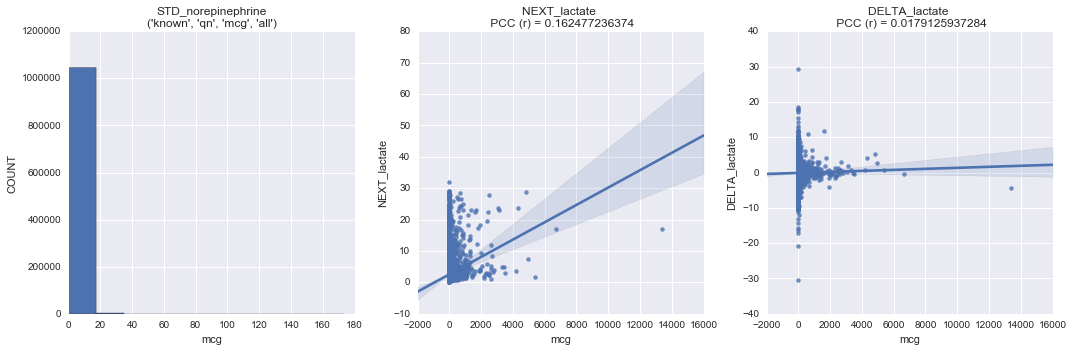

('STD', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all')


STD
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count   1052741.0000
mean          0.0002
std           0.0062
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max           2.5832

0.0
MODE: 0.0
1046794
0.99435093722


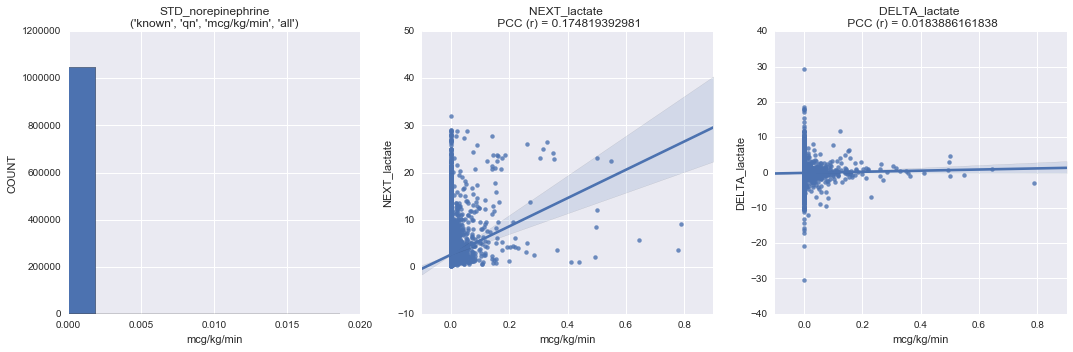

('STD', 'norepinephrine', 'known', 'qn', 'mcg/min', 'all')


STD
      norepinephrine
               known
                  qn
             mcg/min
                 all
count   1052741.0000
mean          0.0003
std           0.0417
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          26.0193

0.0
MODE: 0.0
1052551
0.999819518761


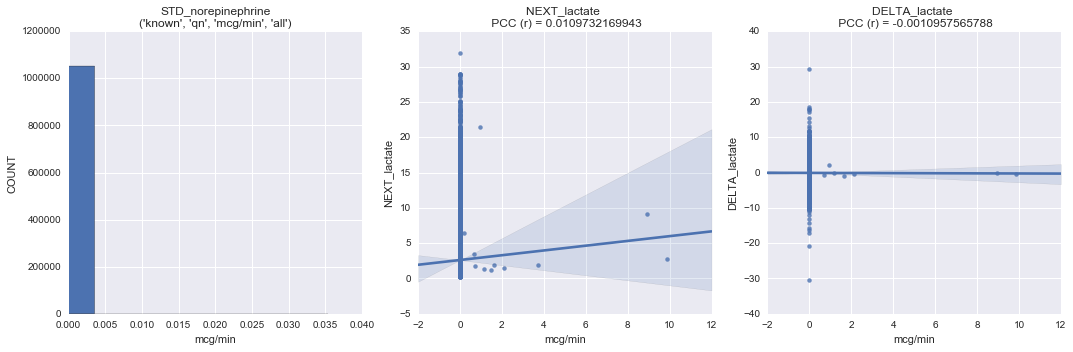

('STD', 'normal saline', 'known', 'qn', 'mL', 'all')


STD
      normal saline
              known
                 qn
                 mL
                all
count  1052741.0000
mean         0.0617
std          5.7976
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       2828.4271

0.0
MODE: 0.0
1052231
0.999515550359


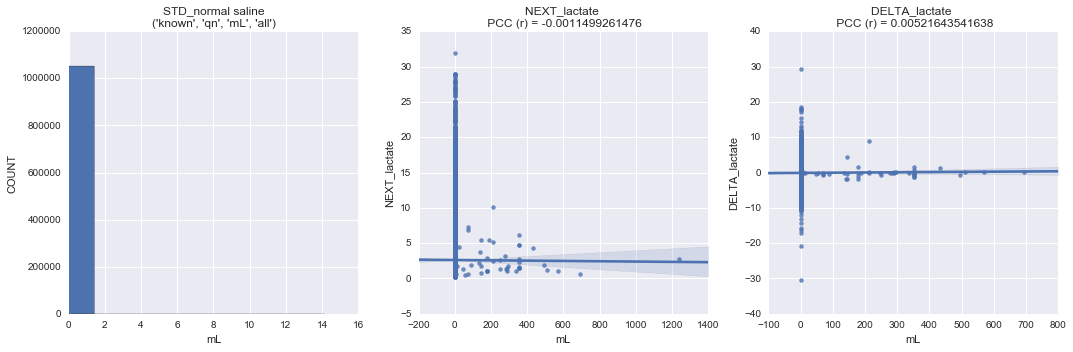

('STD', 'normal saline', 'known', 'qn', 'mL/hr', 'all')


STD
      normal saline
              known
                 qn
              mL/hr
                all
count  1052741.0000
mean         0.7868
std         17.5035
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       3810.6991

0.0
MODE: 0.0
1037698
0.985710635379


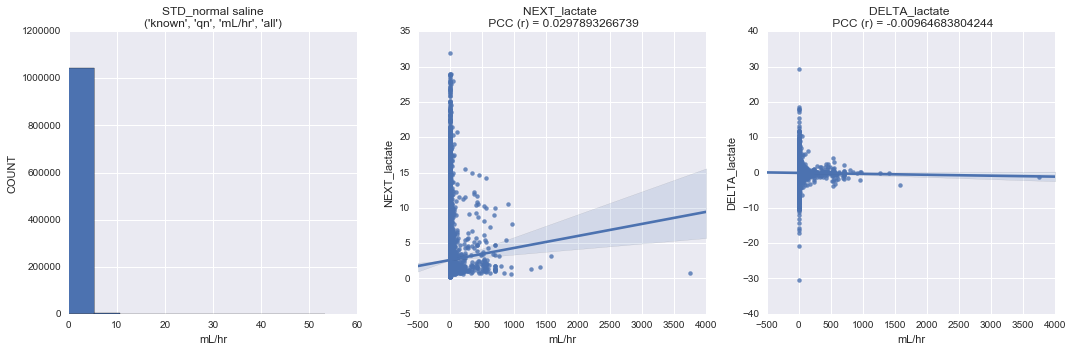

('STD', 'output urine', 'known', 'qn', 'mL', 'all')


STD
       output urine
              known
                 qn
                 mL
                all
count  1052741.0000
mean         7.2157
std         35.6271
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max      17518.5705

0.0
MODE: 0.0
887029
0.842589962773


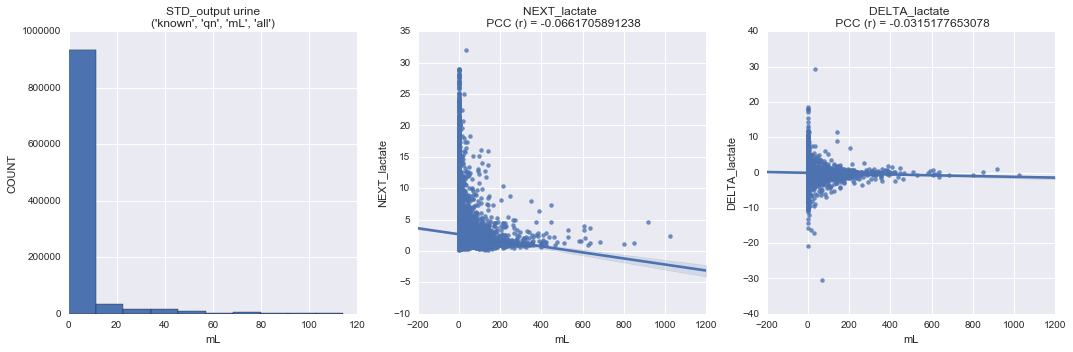

('STD', 'output urine', 'unknown', 'qn', 'no_units', 'all')


STD
       output urine
            unknown
                 qn
           no_units
                all
count  1052741.0000
mean         0.0000
std          0.0000
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          0.0000

0.0
MODE: 0.0
1052741
1.0


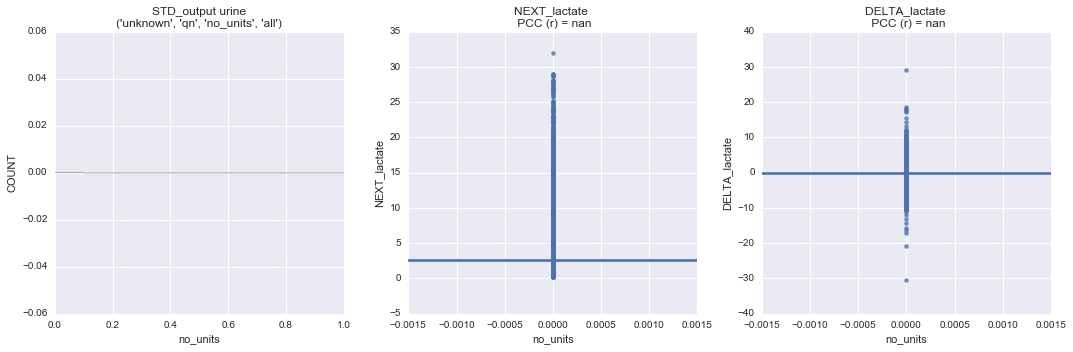

('STD', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all')


STD
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                     1052741.0000
mean                            0.3485
std                             1.1551
min                             0.0000
25%                             0.0000
50%                             0.0000
75%                             0.0000
max                            70.7107

0.0
MODE: 0.0
817147
0.776208963078


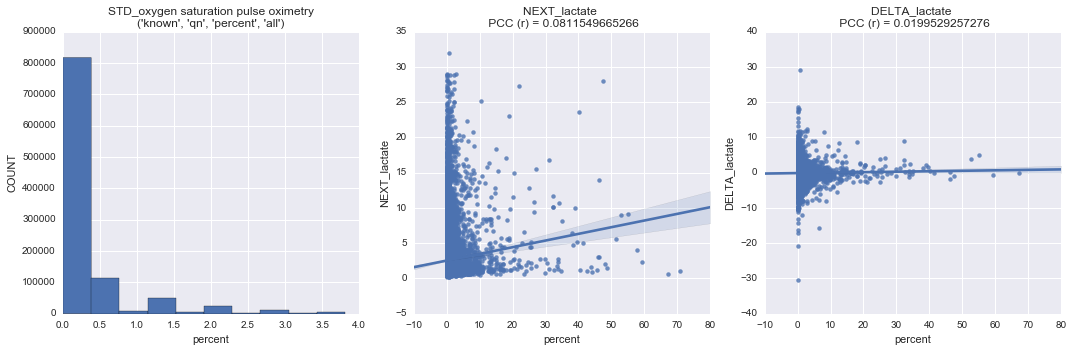

('STD', 'respiratory rate', 'known', 'qn', 'insp/min', 'all')


STD
      respiratory rate
                 known
                    qn
              insp/min
                   all
count     1052741.0000
mean            0.8407
std             1.9284
min             0.0000
25%             0.0000
50%             0.0000
75%             0.7071
max            70.7107

0.0
MODE: 0.0
747284
0.709846011507


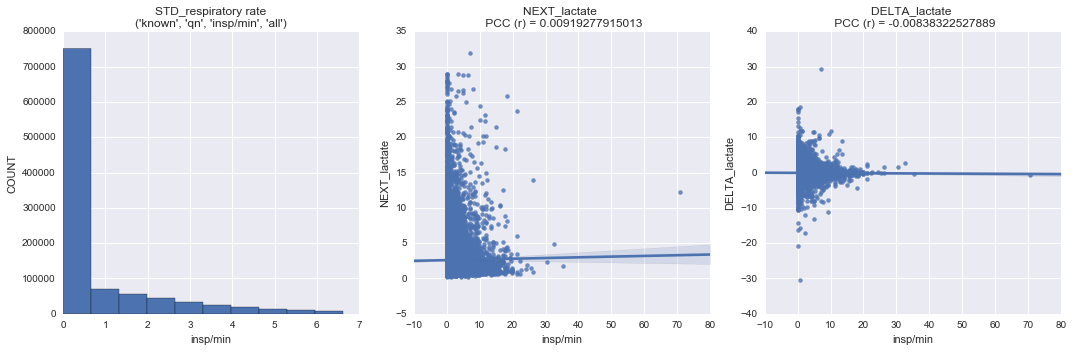

('STD', 'respiratory rate', 'unknown', 'qn', 'Breath', 'all')


STD
      respiratory rate
               unknown
                    qn
                Breath
                   all
count     1052741.0000
mean            1.1149
std             3.7309
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            70.7107

0.0
MODE: 0.0
916579
0.87065954494


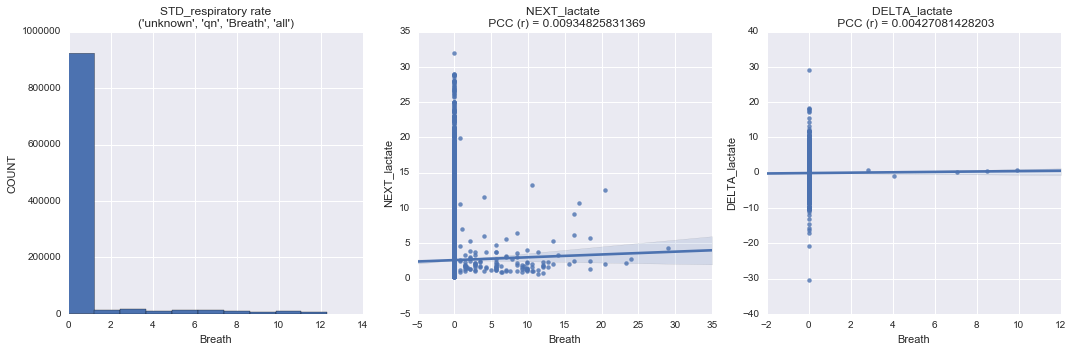

('STD', 'temperature body', 'known', 'qn', 'degF', 'all')


STD
      temperature body
                 known
                    qn
                  degF
                   all
count     1052741.0000
mean            0.0120
std             0.4297
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            72.1249

0.0
MODE: 0.0
1024757
0.973417963203


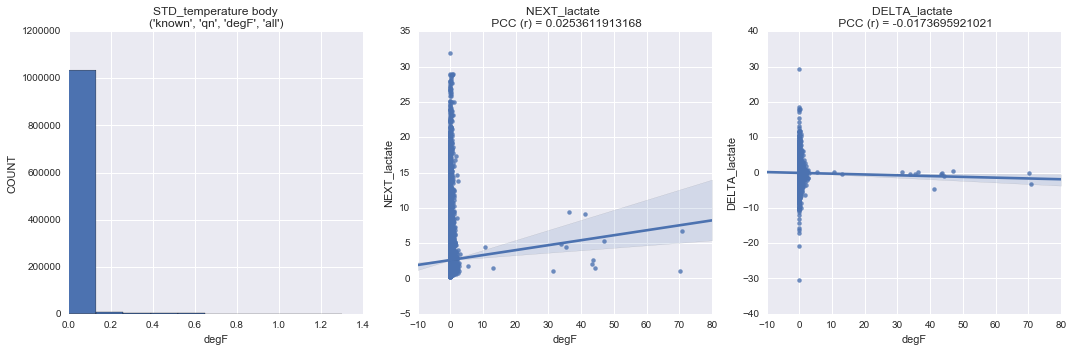

('STD', 'vasopressin', 'known', 'qn', 'units', 'all')


STD
        vasopressin
              known
                 qn
              units
                all
count  1052741.0000
mean         0.0009
std          0.0543
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max         18.7383

0.0
MODE: 0.0
1051930
0.99922963008


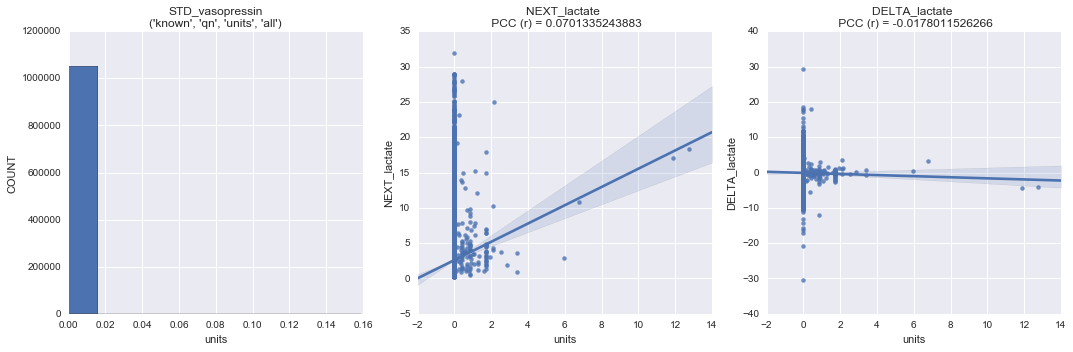

('STD', 'vasopressin', 'known', 'qn', 'units/min', 'all')


STD
        vasopressin
              known
                 qn
          units/min
                all
count  1052741.0000
mean         0.0001
std          0.0088
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.6971

0.0
MODE: 0.0
1052239
0.999523149569


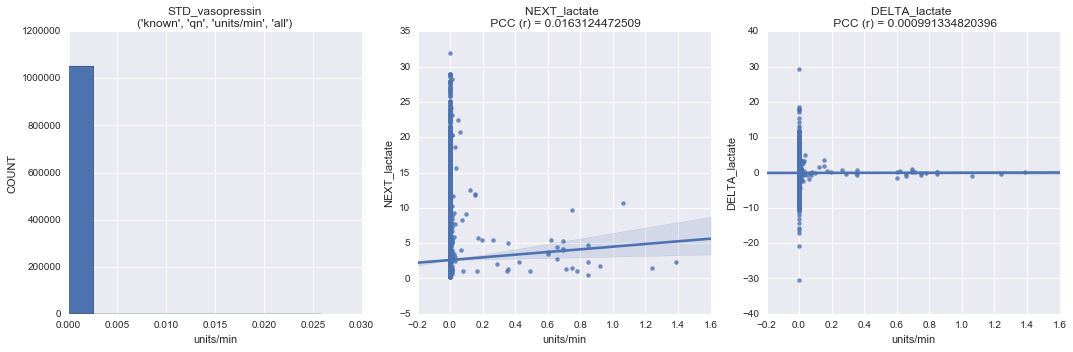

('STD', 'weight body', 'known', 'qn', 'kg', 'all')


STD
        weight body
              known
                 qn
                 kg
                all
count  1052741.0000
mean         0.0004
std          0.1486
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max         78.9131

0.0
MODE: 0.0
1052693
0.99995440474


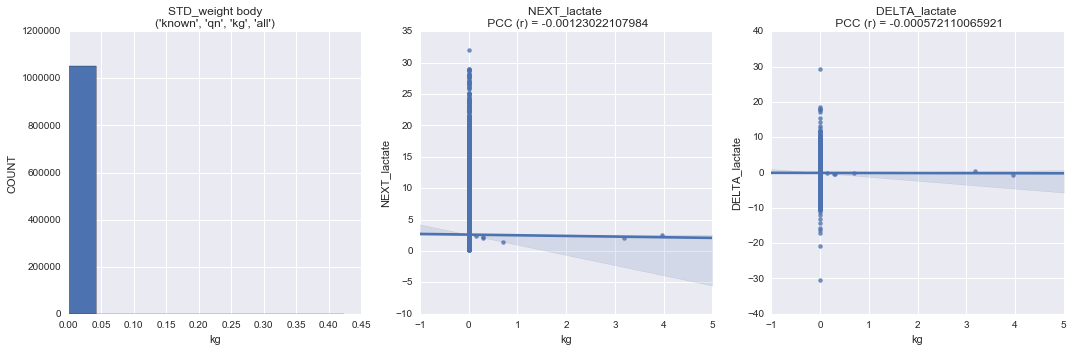

('SUM', 'lactated ringers', 'known', 'qn', 'mL', 'all')


SUM
      lactated ringers
                 known
                    qn
                    mL
                   all
count     1052741.0000
mean            7.7000
std            91.9219
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max         12000.0000

0.0
MODE: 0.0
1028662
0.977127327614


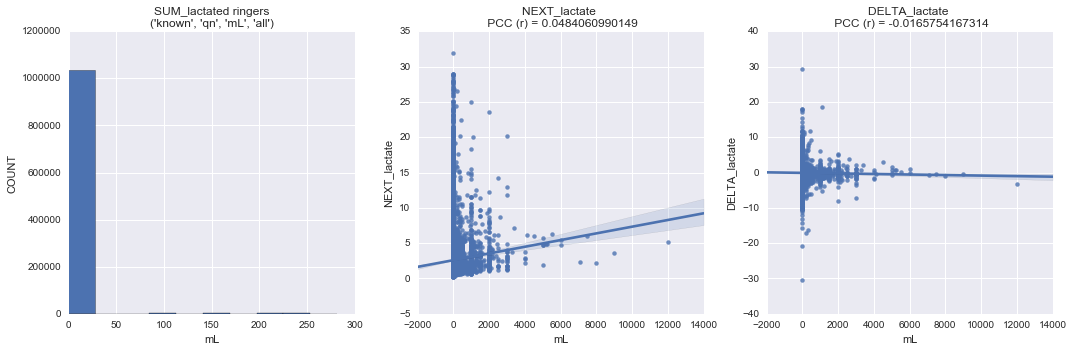

('SUM', 'norepinephrine', 'known', 'qn', 'mcg', 'all')


SUM
      norepinephrine
               known
                  qn
                 mcg
                 all
count   1052741.0000
mean         22.5283
std         325.7165
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max       65280.0000

0.0
MODE: 0.0
1031452
0.979777552123


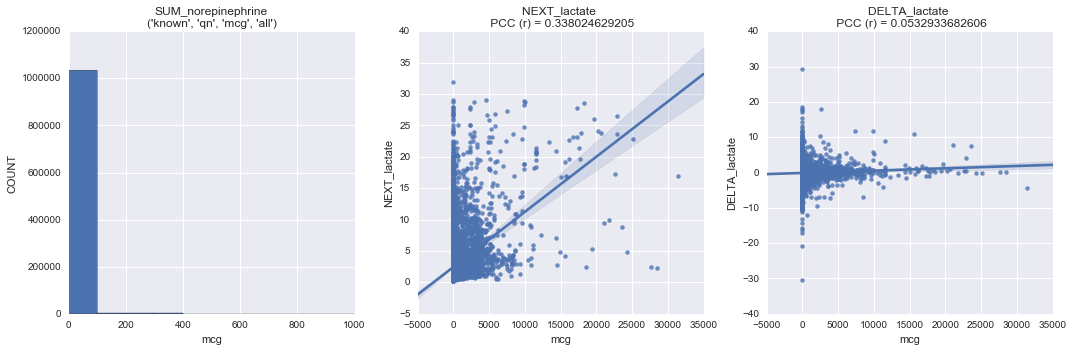

('SUM', 'normal saline', 'known', 'qn', 'mL', 'all')


SUM
      normal saline
              known
                 qn
                 mL
                all
count  1052741.0000
mean         2.6821
std         50.6304
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       6000.0000

0.0
MODE: 0.0
1046893
0.994444977445


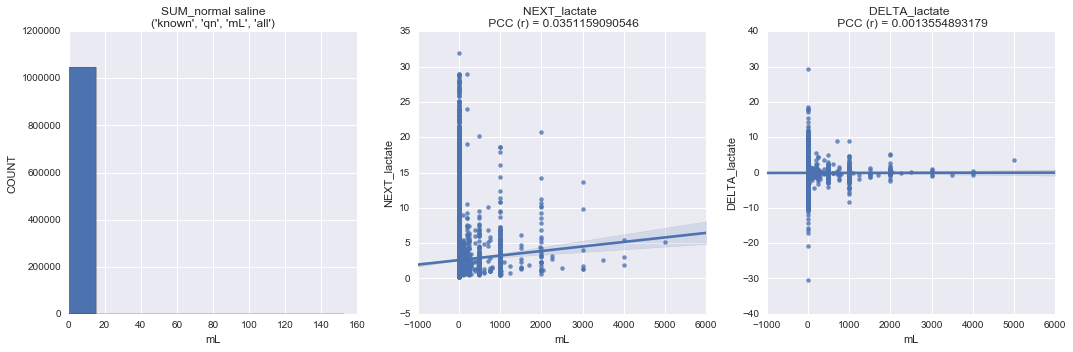

('SUM', 'output urine', 'known', 'qn', 'mL', 'all')


SUM
       output urine
              known
                 qn
                 mL
                all
count  1052741.0000
mean        60.9991
std        147.3740
min          0.0000
25%          0.0000
50%          0.0000
75%         60.0000
max      25275.0000

0.0
MODE: 0.0
732446
0.695751376644


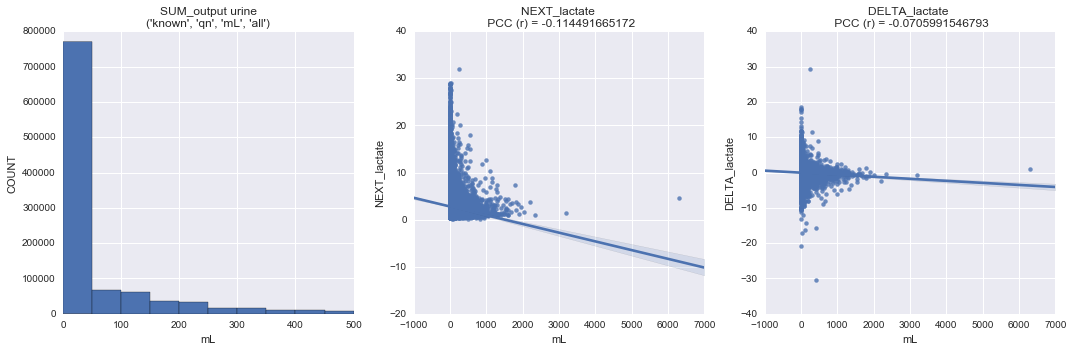

('COUNT', 'blood pressure diastolic', 'known', 'qn', 'mmHg', 'all')


COUNT
      blood pressure diastolic
                         known
                            qn
                          mmHg
                           all
count             1052741.0000
mean                    0.9097
std                     3.0897
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     2.0000
max                   120.0000

0
MODE: 0
650493
0.617904118867


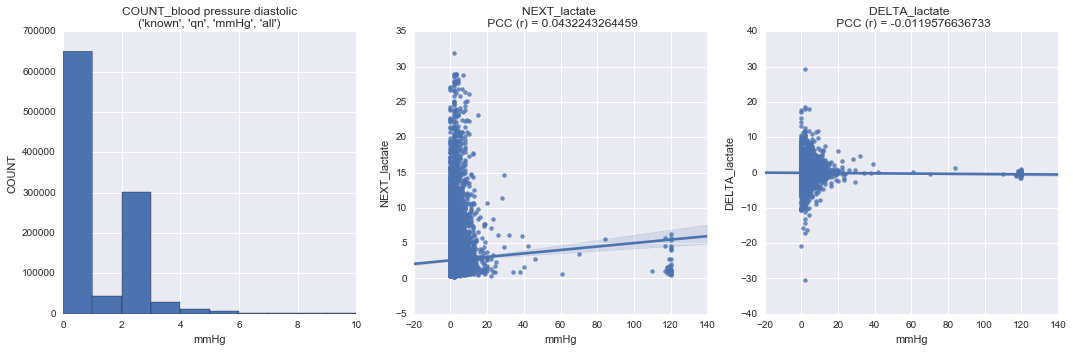

('COUNT', 'blood pressure diastolic', 'unknown', 'qn', 'cc/min', 'all')


COUNT
      blood pressure diastolic
                       unknown
                            qn
                        cc/min
                           all
count             1052741.0000
mean                    0.0269
std                     0.2055
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     0.0000
max                    13.0000

0
MODE: 0
1029393
0.977821705434


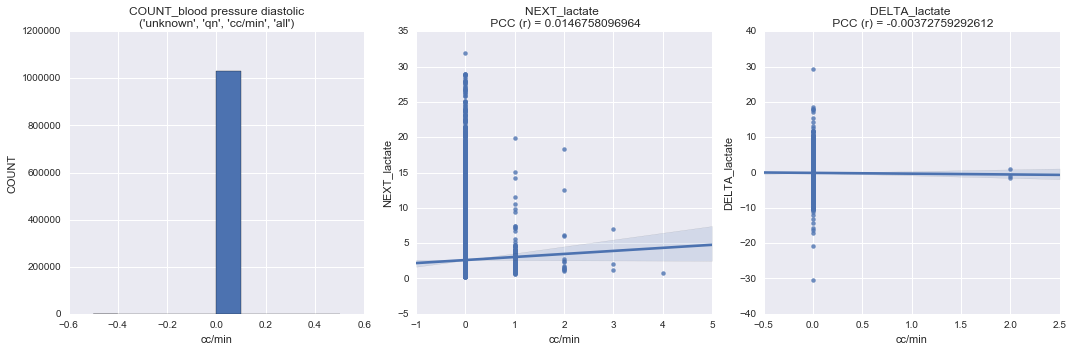

('COUNT', 'blood pressure mean', 'known', 'qn', 'mmHg', 'all')


COUNT
      blood pressure mean
                    known
                       qn
                     mmHg
                      all
count        1052741.0000
mean               0.3939
std                2.9602
min                0.0000
25%                0.0000
50%                0.0000
75%                0.0000
max              120.0000

0
MODE: 0
895830
0.850950043743


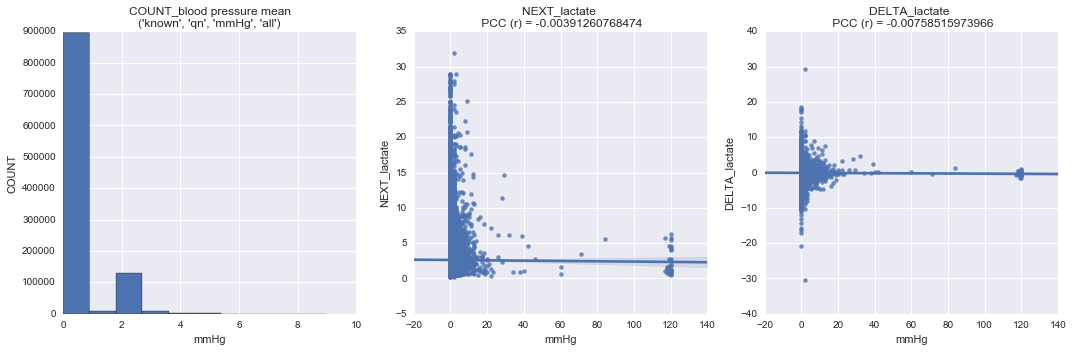

('COUNT', 'blood pressure systolic', 'known', 'qn', 'mmHg', 'all')


COUNT
      blood pressure systolic
                        known
                           qn
                         mmHg
                          all
count            1052741.0000
mean                   0.9093
std                    3.0899
min                    0.0000
25%                    0.0000
50%                    0.0000
75%                    2.0000
max                  120.0000

0
MODE: 0
650969
0.618356271866


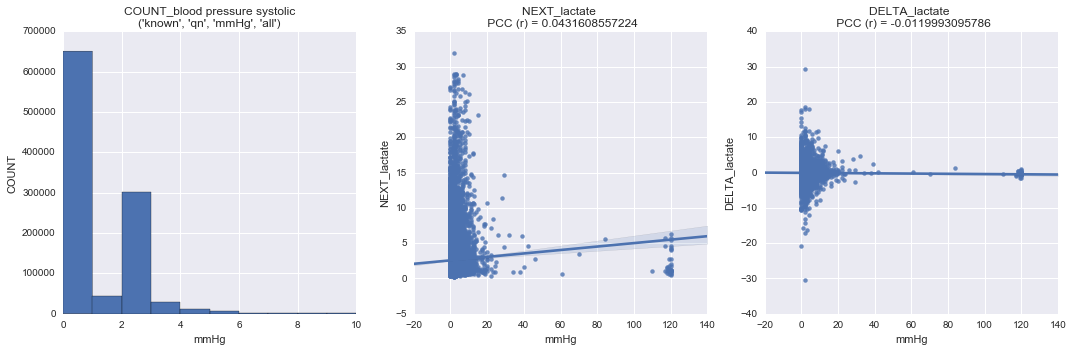

('COUNT', 'blood pressure systolic', 'unknown', 'qn', 'cc/min', 'all')


COUNT
      blood pressure systolic
                      unknown
                           qn
                       cc/min
                          all
count            1052741.0000
mean                   0.0269
std                    0.2057
min                    0.0000
25%                    0.0000
50%                    0.0000
75%                    0.0000
max                   13.0000

0
MODE: 0
1029378
0.977807456915


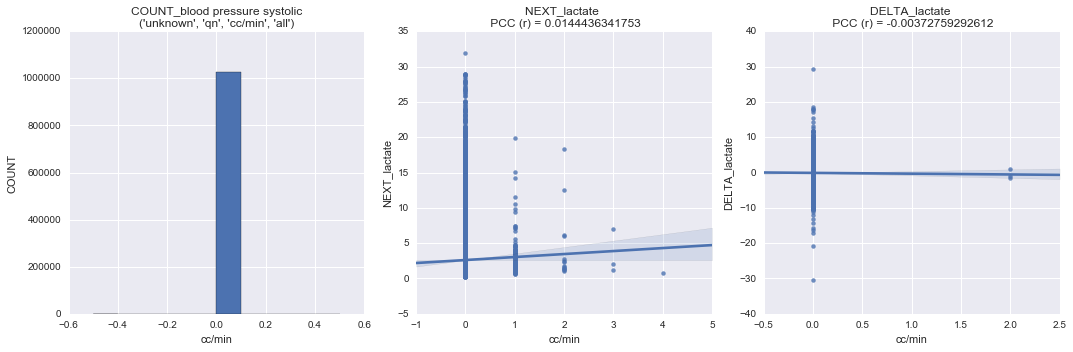

('COUNT', 'glasgow coma scale eye opening', 'known', 'ord', 'no_units', 'all')


COUNT
      glasgow coma scale eye opening
                               known
                                 ord
                            no_units
                                 all
count                   1052741.0000
mean                          0.1461
std                           0.3797
min                           0.0000
25%                           0.0000
50%                           0.0000
75%                           0.0000
max                          10.0000

0
MODE: 0
908686
0.863161974313


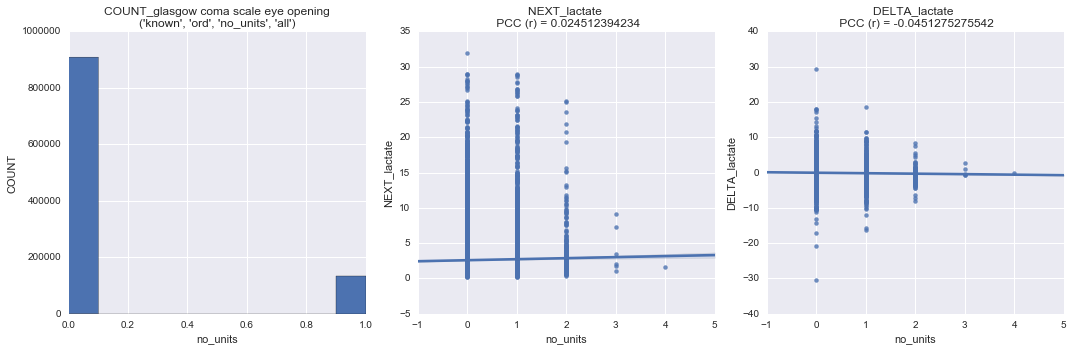

('COUNT', 'glasgow coma scale motor', 'known', 'ord', 'no_units', 'all')


COUNT
      glasgow coma scale motor
                         known
                           ord
                      no_units
                           all
count             1052741.0000
mean                    0.1454
std                     0.3786
min                     0.0000
25%                     0.0000
50%                     0.0000
75%                     0.0000
max                     9.0000

0
MODE: 0
909287
0.863732864969


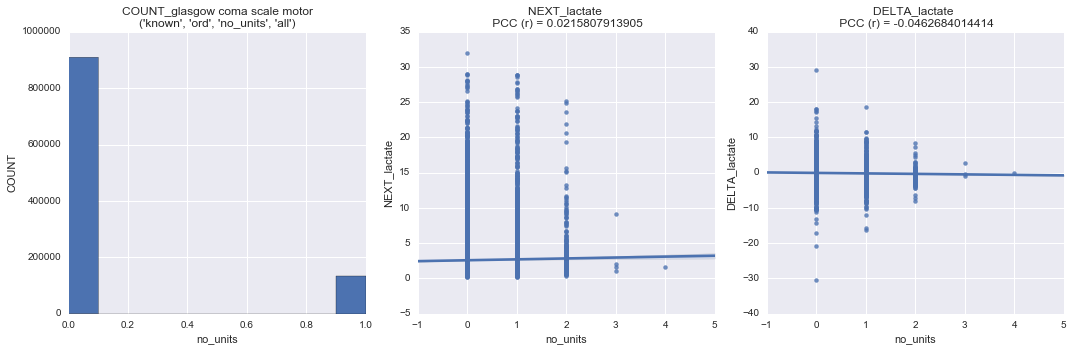

('COUNT', 'glasgow coma scale verbal', 'known', 'ord', 'no_units', 'all')


COUNT
      glasgow coma scale verbal
                          known
                            ord
                       no_units
                            all
count              1052741.0000
mean                     0.1457
std                      0.3792
min                      0.0000
25%                      0.0000
50%                      0.0000
75%                      0.0000
max                     10.0000

0
MODE: 0
908979
0.863440295381


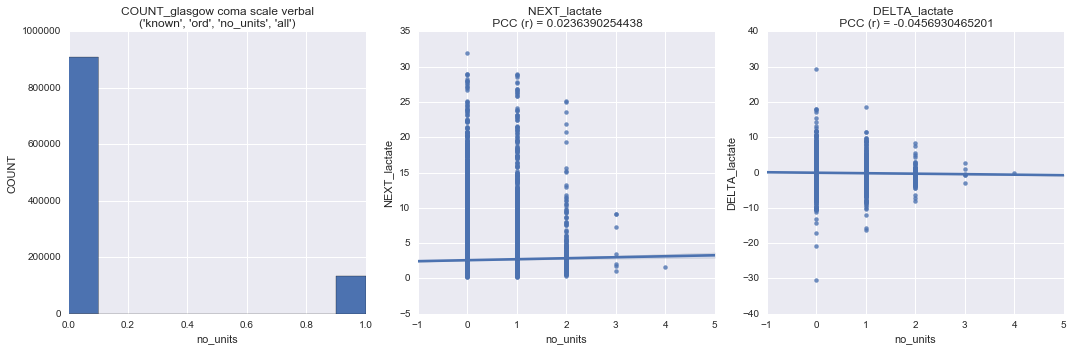

('COUNT', 'heart rate', 'known', 'qn', 'beats/min', 'all')


COUNT
         heart rate
              known
                 qn
          beats/min
                all
count  1052741.0000
mean         1.2580
std          3.7904
min          0.0000
25%          0.0000
50%          1.0000
75%          2.0000
max        120.0000

0
MODE: 0
491865
0.46722318215


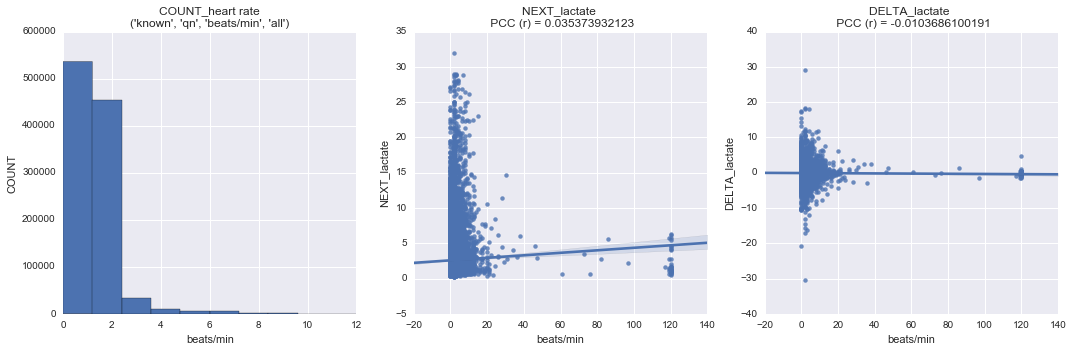

('COUNT', 'hemoglobin', 'known', 'qn', 'g/dL', 'all')


COUNT
         hemoglobin
              known
                 qn
               g/dL
                all
count  1052741.0000
mean         0.1032
std          0.3332
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          7.0000

0
MODE: 0
951197
0.903543226682


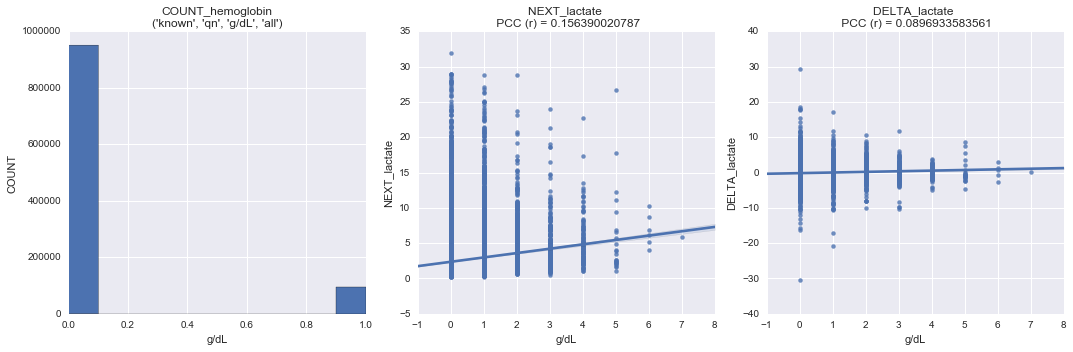

('COUNT', 'lactate', 'known', 'qn', 'mmol/L', 'all')


COUNT
            lactate
              known
                 qn
             mmol/L
                all
count  1052741.0000
mean         0.0268
std          0.1762
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          5.0000

0
MODE: 0
1026766
0.97532631483


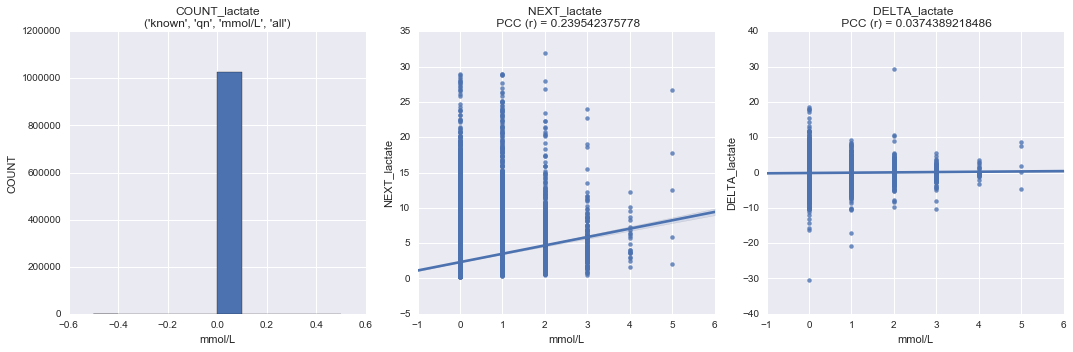

('COUNT', 'lactated ringers', 'known', 'qn', 'mL', 'all')


COUNT
      lactated ringers
                 known
                    qn
                    mL
                   all
count     1052741.0000
mean            0.0374
std             0.2582
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            10.0000

0
MODE: 0
1028177
0.976666625504


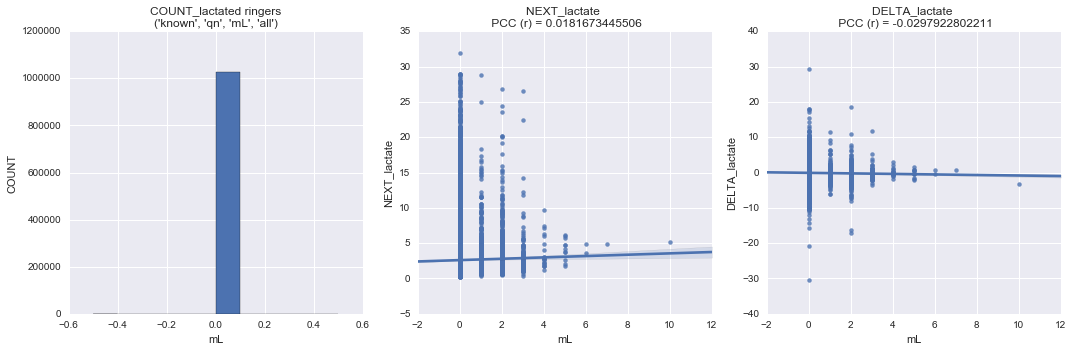

('COUNT', 'lactated ringers', 'known', 'qn', 'mL/hr', 'all')


COUNT
      lactated ringers
                 known
                    qn
                 mL/hr
                   all
count     1052741.0000
mean            0.0003
std             0.0194
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             2.0000

0
MODE: 0
1052392
0.999668484461


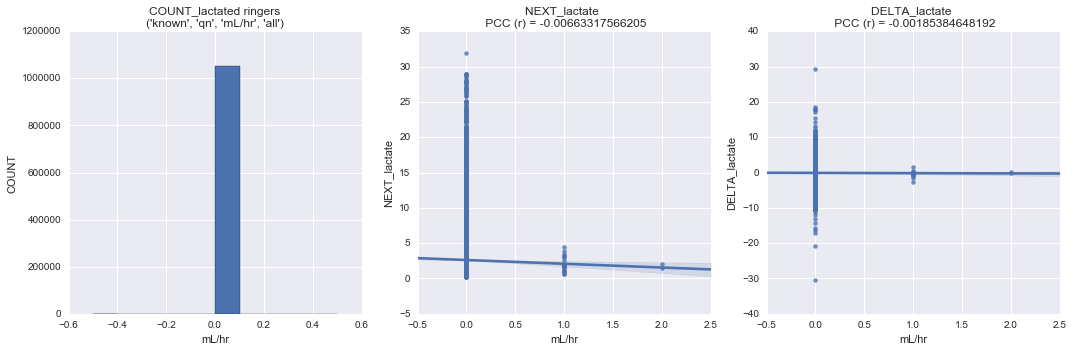

('COUNT', 'lactated ringers', 'unknown', 'qn', 'no_units', 'all')


COUNT
      lactated ringers
               unknown
                    qn
              no_units
                   all
count     1052741.0000
mean            0.0007
std             0.0258
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             2.0000

0
MODE: 0
1052041
0.99933506912


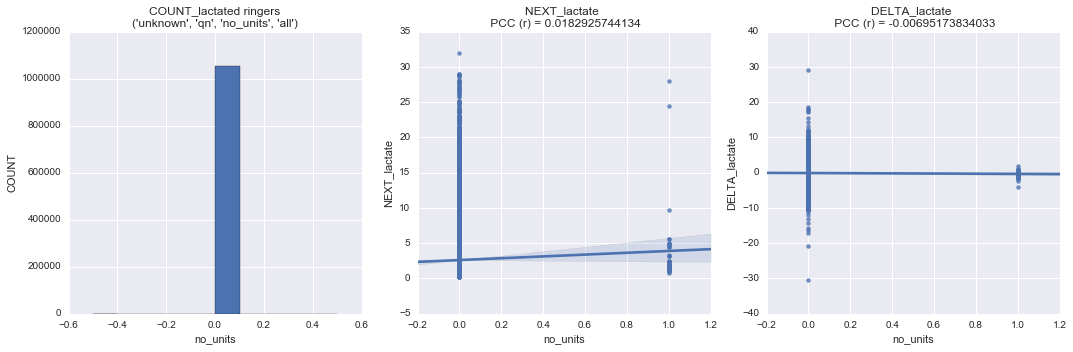

('COUNT', 'norepinephrine', 'known', 'qn', 'mcg', 'all')


COUNT
      norepinephrine
               known
                  qn
                 mcg
                 all
count   1052741.0000
mean          0.0387
std           0.2787
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          12.0000

0
MODE: 0
1029744
0.978155120775


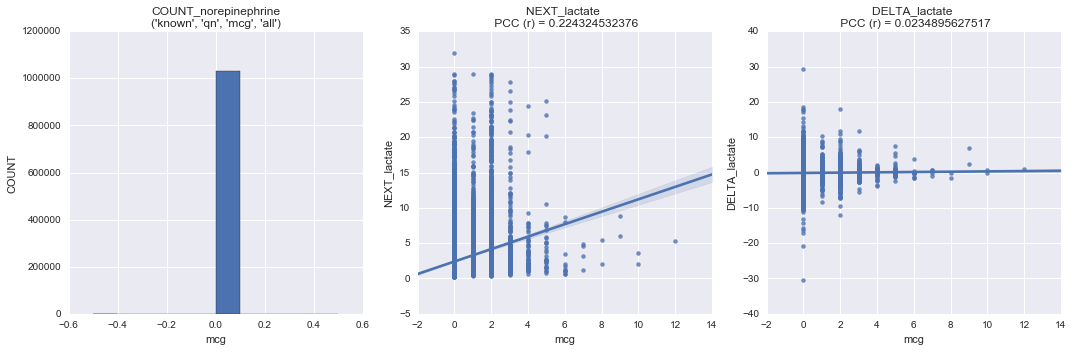

('COUNT', 'norepinephrine', 'known', 'qn', 'mcg/kg/min', 'all')


COUNT
      norepinephrine
               known
                  qn
          mcg/kg/min
                 all
count   1052741.0000
mean          0.0436
std           0.4062
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          24.0000

0
MODE: 0
1036010
0.984107202056


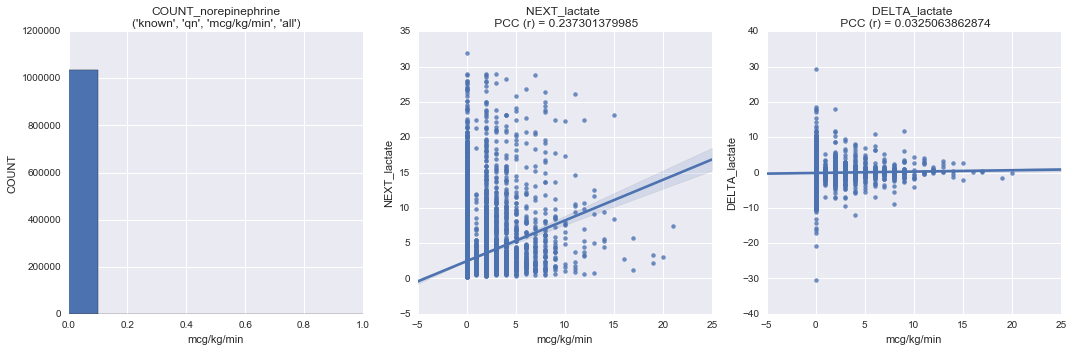

('COUNT', 'norepinephrine', 'known', 'qn', 'mcg/min', 'all')


COUNT
      norepinephrine
               known
                  qn
             mcg/min
                 all
count   1052741.0000
mean          0.0013
std           0.0651
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          12.0000

0
MODE: 0
1052165
0.999452856876


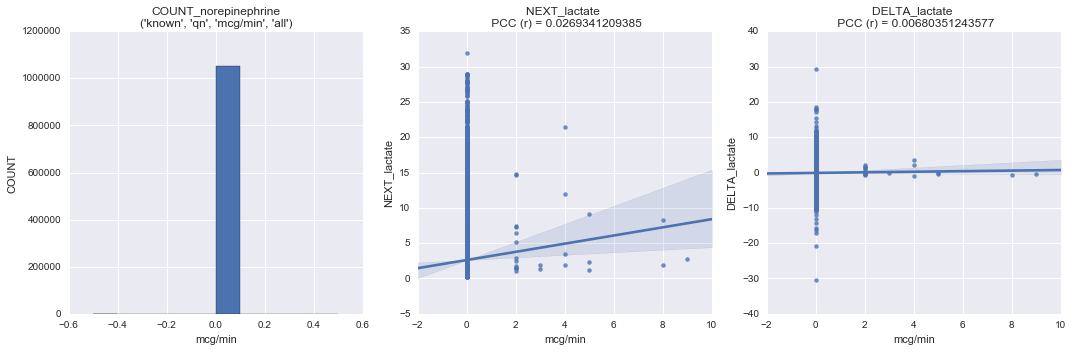

('COUNT', 'normal saline', 'known', 'qn', 'mL', 'all')


COUNT
      normal saline
              known
                 qn
                 mL
                all
count  1052741.0000
mean         0.0066
std          0.0958
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          7.0000

0
MODE: 0
1046887
0.994439278037


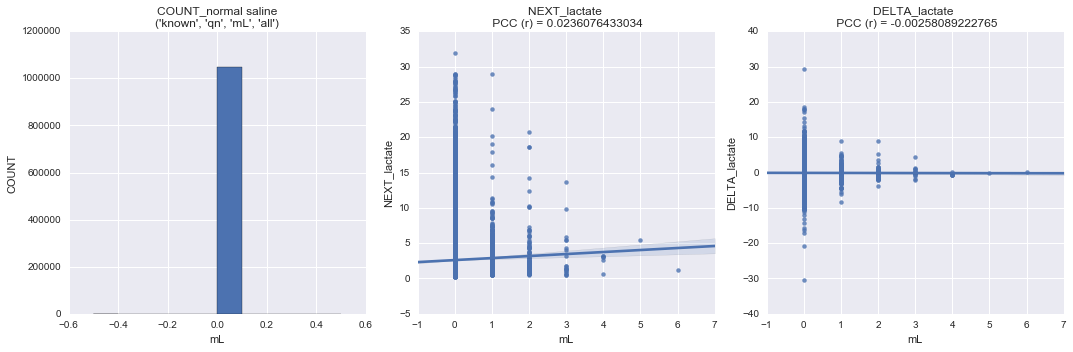

('COUNT', 'normal saline', 'known', 'qn', 'mL/hr', 'all')


COUNT
      normal saline
              known
                 qn
              mL/hr
                all
count  1052741.0000
mean         0.0666
std          0.4027
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max         15.0000

0
MODE: 0
1011391
0.960721582991


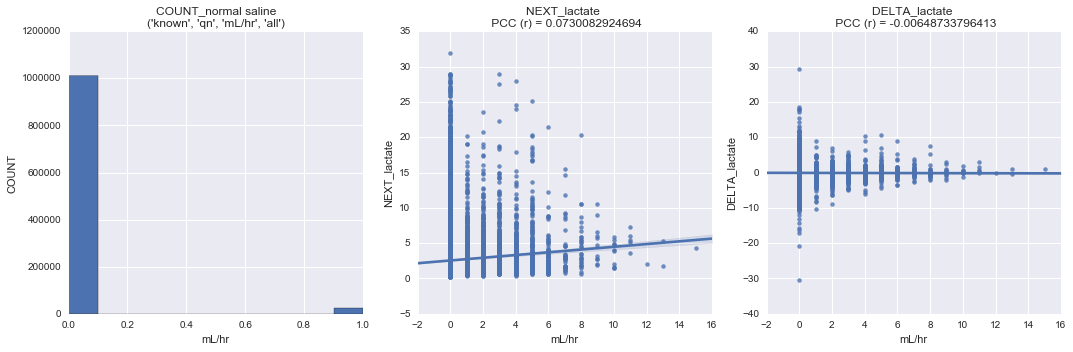

('COUNT', 'output urine', 'known', 'qn', 'mL', 'all')


COUNT
       output urine
              known
                 qn
                 mL
                all
count  1052741.0000
mean         0.4907
std          0.7905
min          0.0000
25%          0.0000
50%          0.0000
75%          1.0000
max          8.0000

0
MODE: 0
729142
0.692612902889


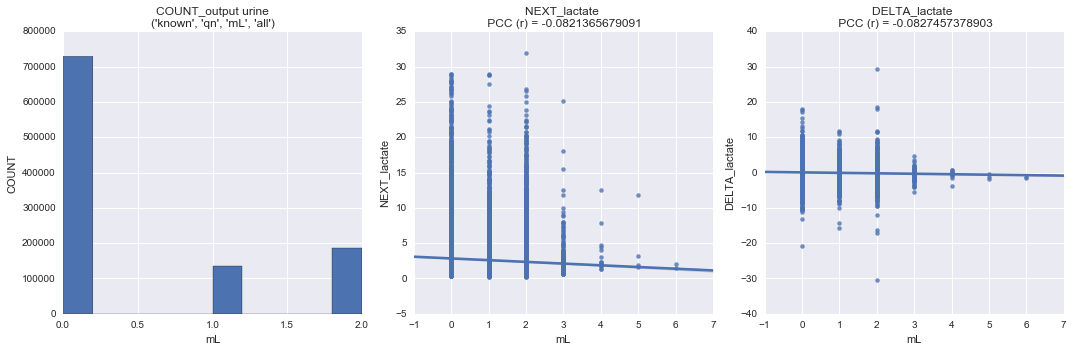

('COUNT', 'output urine', 'unknown', 'qn', 'no_units', 'all')


COUNT
       output urine
            unknown
                 qn
           no_units
                all
count  1052741.0000
mean         0.0006
std          0.0243
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000

0
MODE: 0
1052117
0.999407261615


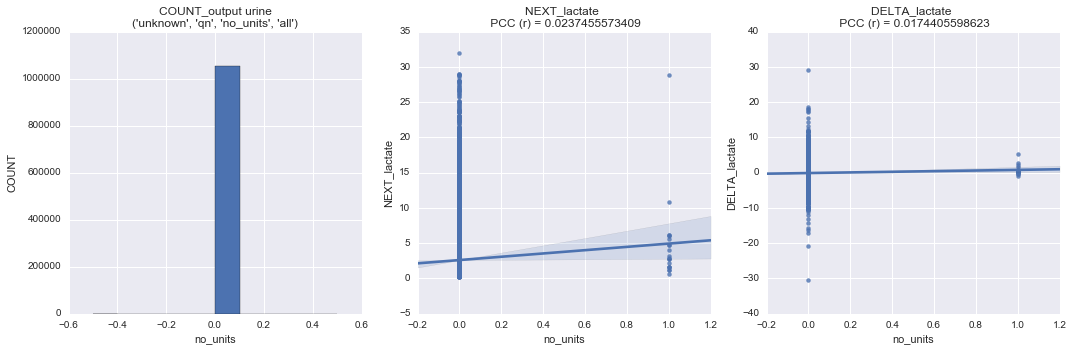

('COUNT', 'oxygen saturation pulse oximetry', 'known', 'qn', 'percent', 'all')


COUNT
      oxygen saturation pulse oximetry
                                 known
                                    qn
                               percent
                                   all
count                     1052741.0000
mean                            0.9336
std                             3.5688
min                             0.0000
25%                             0.0000
50%                             0.0000
75%                             2.0000
max                           120.0000

0
MODE: 0
657773
0.624819400023


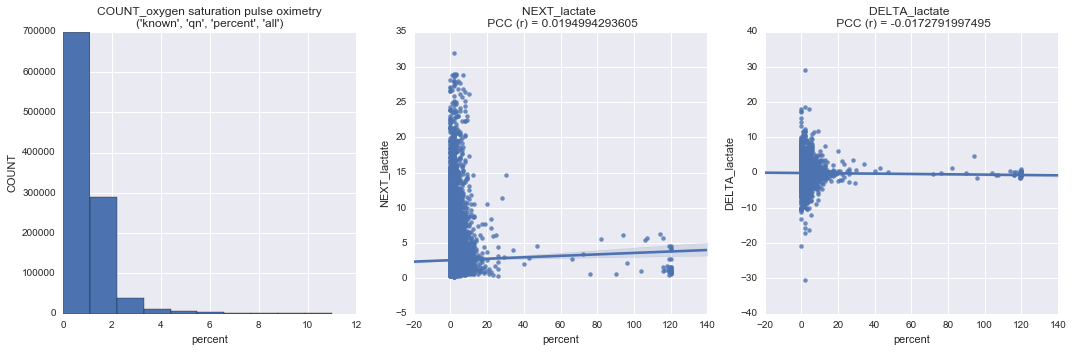

('COUNT', 'respiratory rate', 'known', 'qn', 'insp/min', 'all')


COUNT
      respiratory rate
                 known
                    qn
              insp/min
                   all
count     1052741.0000
mean            0.9435
std             3.7511
min             0.0000
25%             0.0000
50%             0.0000
75%             2.0000
max           120.0000

0
MODE: 0
653517
0.62077662027


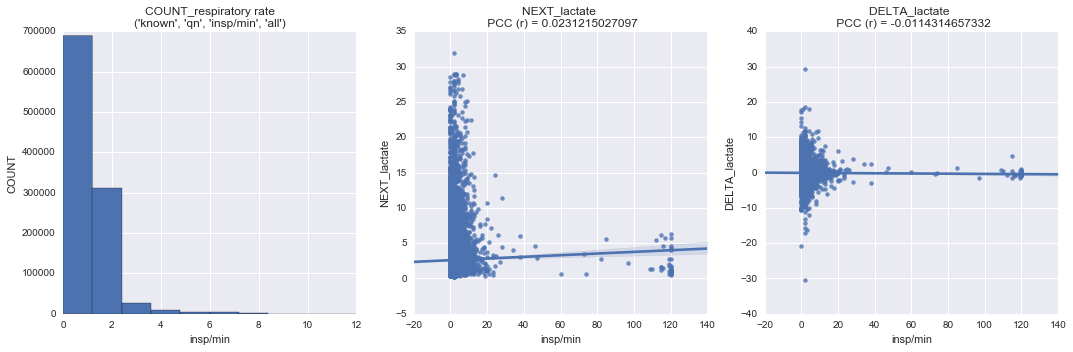

('COUNT', 'respiratory rate', 'unknown', 'qn', 'Breath', 'all')


COUNT
      respiratory rate
               unknown
                    qn
                Breath
                   all
count     1052741.0000
mean            0.2901
std             0.7215
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            15.0000

0
MODE: 0
899357
0.854300345479


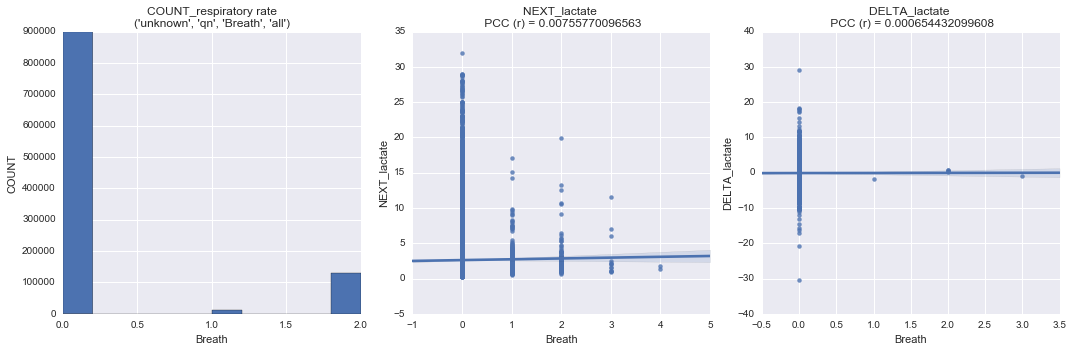

('COUNT', 'temperature body', 'known', 'qn', 'degF', 'all')


COUNT
      temperature body
                 known
                    qn
                  degF
                   all
count     1052741.0000
mean            0.2609
std             0.6199
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max            57.0000

0
MODE: 0
832316
0.790618015257


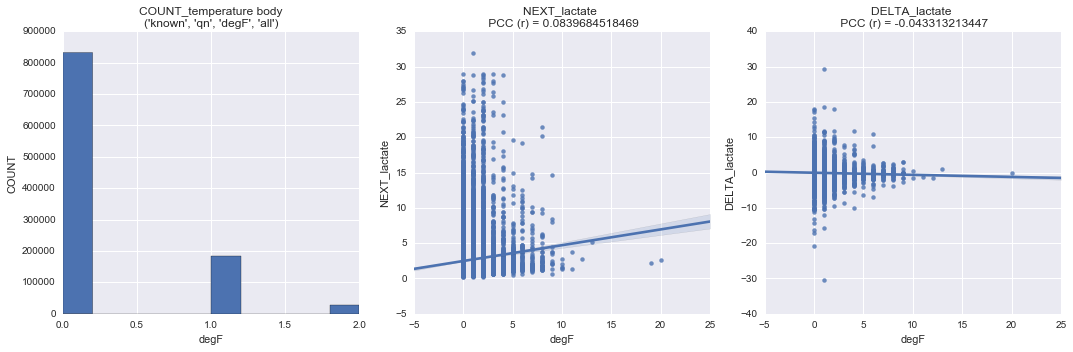

('COUNT', 'vasopressin', 'known', 'qn', 'units', 'all')


COUNT
        vasopressin
              known
                 qn
              units
                all
count  1052741.0000
mean         0.0095
std          0.1358
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          6.0000

0
MODE: 0
1047326
0.994856284689


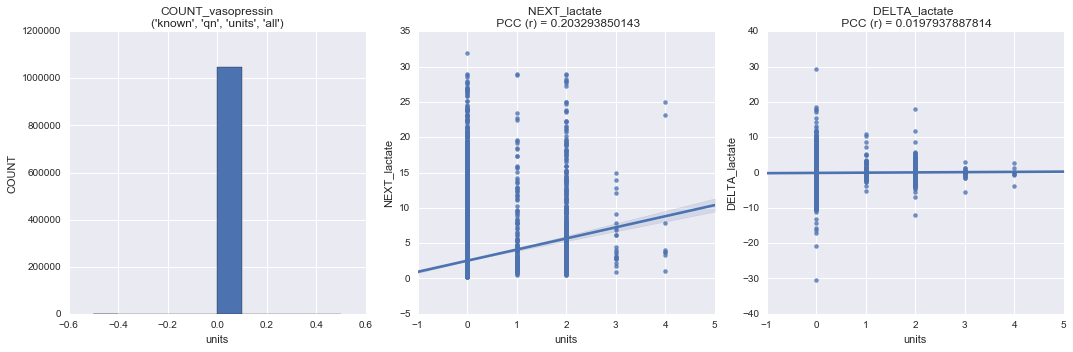

('COUNT', 'vasopressin', 'known', 'qn', 'units/min', 'all')


COUNT
        vasopressin
              known
                 qn
          units/min
                all
count  1052741.0000
mean         0.0171
std          0.2433
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max         18.0000

0
MODE: 0
1045537
0.993156911339


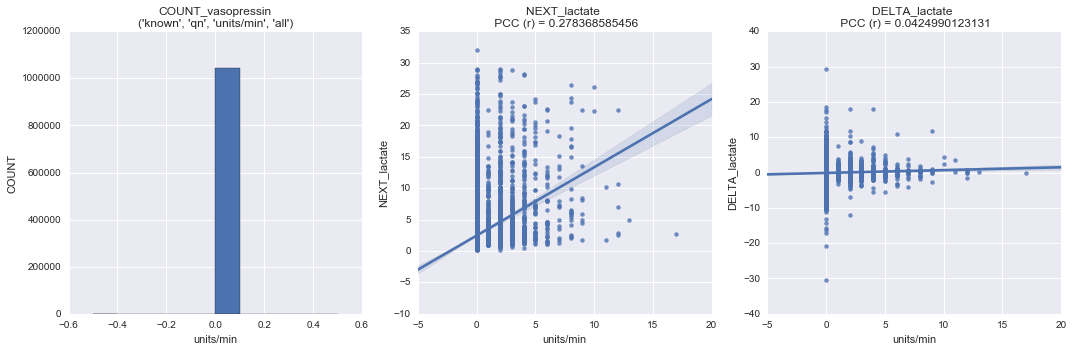

('COUNT', 'weight body', 'known', 'qn', 'kg', 'all')


COUNT
        weight body
              known
                 qn
                 kg
                all
count  1052741.0000
mean         0.0140
std          0.1255
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          5.0000

0
MODE: 0
1038909
0.986860965803


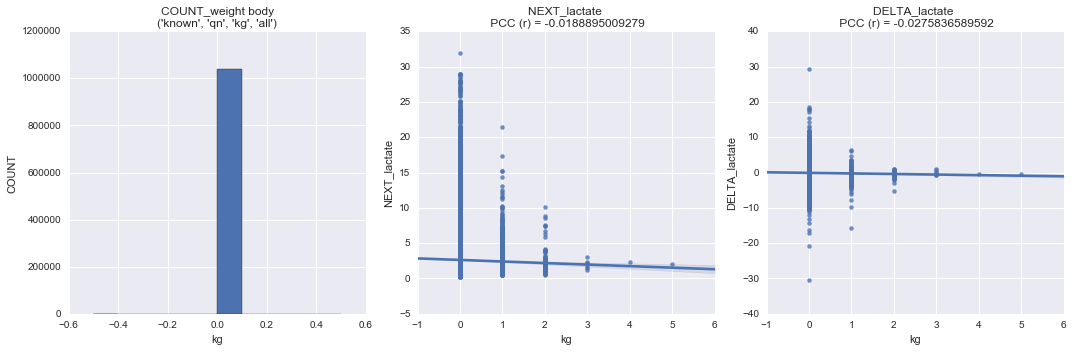

('COUNT', 'output urine', 'unknown', 'nom', 'no_units', '3686(ml)_No Void')


COUNT
          output urine
               unknown
                   nom
              no_units
      3686(ml)_No Void
count     1052741.0000
mean            0.0007
std             0.0276
min             0.0000
25%             0.0000
50%             0.0000
75%             0.0000
max             2.0000

0.0
MODE: 0.0
1051975
0.999272375637


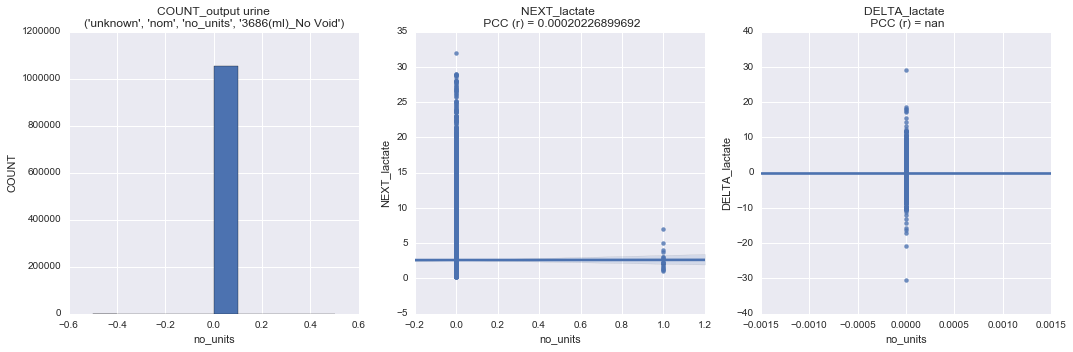

('COUNT', 'output urine', 'unknown', 'nom', 'no_units', '3686(ml)_Voiding qs')


COUNT
             output urine
                  unknown
                      nom
                 no_units
      3686(ml)_Voiding qs
count        1052741.0000
mean               0.0682
std                0.2528
min                0.0000
25%                0.0000
50%                0.0000
75%                0.0000
max                2.0000

0.0
MODE: 0.0
981183
0.932026965797


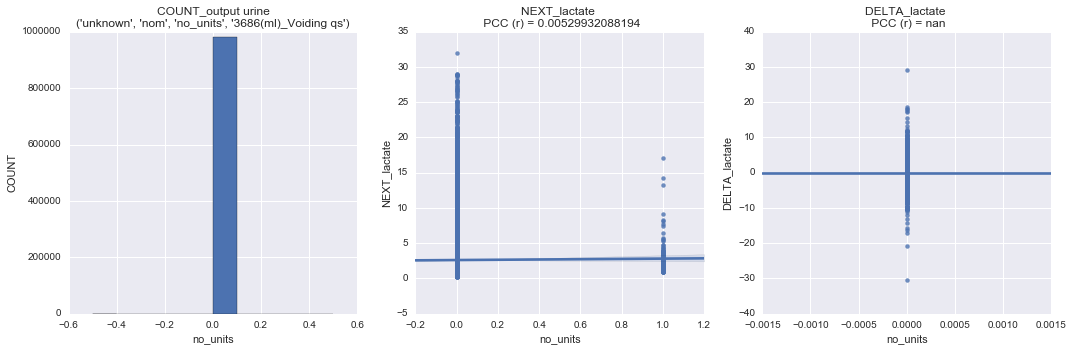

('COUNT', 'output urine', 'unknown', 'nom', 'no_units', '3686_Voiding qs')


COUNT
         output urine
              unknown
                  nom
             no_units
      3686_Voiding qs
count    1052741.0000
mean           0.0001
std            0.0104
min            0.0000
25%            0.0000
50%            0.0000
75%            0.0000
max            1.0000

0.0
MODE: 0.0
1052627
0.999891711257


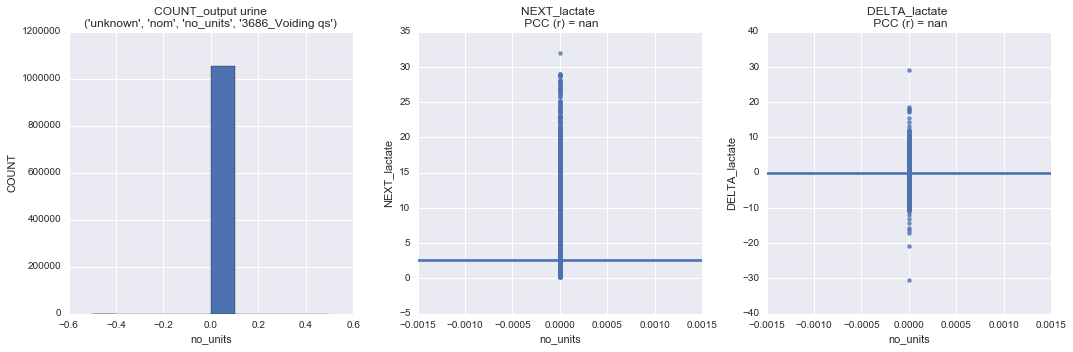

In [31]:
df_corr = viz_per_feature(df_features,label_dict)

In [34]:
df_corr.sort_values('DELTA_lactate')

NEXT_lactate  \
feature component                        status  variable_type units      description                        
MEAN    lactate                          known   qn            mmol/L     all                     0.781988   
LAST    lactate                          known   qn            mmol/L     all                     0.791466   
COUNT   output urine                     known   qn            mL         all                   -0.0821366   
LAST    hemoglobin                       known   qn            g/dL       all                  -0.00764777   
MEAN    hemoglobin                       known   qn            g/dL       all                  -0.00811088   
SUM     output urine                     known   qn            mL         all                    -0.114492   
LAST    oxygen saturation pulse oximetry known   qn            percent    all                    -0.145341   
MEAN    oxygen saturation pulse oximetry known   qn            percent    all                    -0.156621   
COUNT   glasgow coma scale motor         known   ord           no_units   all                    0.0215808   
MEAN    blood pressure diastolic         known   qn            mmHg       all                   -0.0784892   
COUNT   glasgow coma scale verbal        known   ord           no_units   all                     0.023639   
        glasgow coma scale eye opening   known   ord           no_units   all                    0.0245124   
LAST    blood pressure diastolic         known   qn            mmHg       all                    -0.071934   
COUNT   temperature body                 known   qn            degF       all                    0.0839685   
LAST    blood pressure systolic          known   qn            mmHg       all                    -0.144036   
MEAN    blood pressure systolic          known   qn            mmHg       all                    -0.158202   
STD     output urine                     known   qn            mL         all                   -0.0661706   
        blood pressure systolic          known   qn            mmHg       all                   0.00282336   
        blood pressure diastolic         known   qn            mmHg       all                  -0.00846355   
COUNT   lactated ringers                 known   qn            mL         all                    0.0181673   
        weight body                      known   qn            kg         all                   -0.0188895   
STD     glasgow coma scale motor         known   ord           no_units   all                   0.00631426   
        vasopressin                      known   qn            units      all                    0.0701335   
        temperature body                 known   qn            degF       all                    0.0253612   
COUNT   oxygen saturation pulse oximetry known   qn            percent    all                    0.0194994   
SUM     lactated ringers                 known   qn            mL         all                    0.0484061   
STD     heart rate                       known   qn            beats/min  all                    0.0202792   
        glasgow coma scale eye opening   known   ord           no_units   all                   0.00174732   
COUNT   blood pressure systolic          known   qn            mmHg       all                    0.0431609   
        blood pressure diastolic         known   qn            mmHg       all                    0.0432243   
...                                                                                                    ...   
        output urine                     unknown qn            no_units   all                    0.0237456   
STD     norepinephrine                   known   qn            mcg        all                     0.162477   
                                                               mcg/kg/min all                     0.174819   
COUNT   vasopressin                      known   qn            units      all                     0.203294   
STD     oxygen saturatio

In [44]:
components = features.components_for_features(factory.features,data_dict,panel_id=12)
root = factory._key(train_subset)
joined_path = '{}/{}'.format(root,utils.make_list_hash(components))

In [47]:
store = pd.HDFStore(factory.hdf5_fname_target)

In [49]:
df_joined = utils.read_and_reconstruct(factory.hdf5_fname_target,joined_path)

In [72]:
df_q2h = df_joined.groupby(level='id').resample(rule='2H',level=column_names.DATETIME).mean()

In [73]:
df_q2h.shape

(1052741, 31)

In [74]:
df_q2h.dropna(how='all').shape

(616331, 31)

In [76]:
df_q2h.index.get_level_values('id').unique().size

9339

In [78]:
df_q2h.dropna(how='all').index.get_level_values('id').unique().size

9339

In [82]:
total_data = df_q2h.groupby(level='id').count().sum(axis=1)

In [87]:
df_q2h.loc[total_data.loc[total_data.sort_values() == 1].index.unique().tolist()]

component                  blood pressure diastolic          \
status                                        known unknown   
variable_type                                    qn      qn   
units                                          mmHg  cc/min   
description                                     all     all   
id     datetime                                               
101448 2192-12-03 06:00:00                      NaN     NaN   
102476 2146-02-07 22:00:00                      NaN     NaN   
103459 2159-08-09 22:00:00                      NaN     NaN   
108103 2181-02-09 04:00:00                      NaN     NaN   
110775 2179-01-07 18:00:00                      NaN     NaN   
114037 2197-01-27 02:00:00                      NaN     NaN   
125306 2163-03-02 22:00:00                      NaN     NaN   
125447 2138-08-16 00:00:00                      NaN     NaN   
127606 2135-07-31 10:00:00                      NaN     NaN   
129284 2116-05-08 06:00:00                      NaN     NaN   
131067 2184-03-18 02:00:00                      NaN     NaN   
134929 2154-03-04 18:00:00                      NaN     NaN   
137584 2128-06-05 04:00:00                      NaN     NaN   
137640 2183-05-27 02:00:00                      NaN     NaN   
144127 2114-03-01 14:00:00                      NaN     NaN   
148231 2183-02-22 10:00:00                      NaN     NaN   
156895 2113-08-31 02:00:00                      NaN     NaN   
157725 2159-11-19 08:00:00                      NaN     NaN   
158613 2191-04-07 16:00:00                      NaN     NaN   
160895 2183-08-03 04:00:00                      NaN     NaN   
165499 2140-02-24 12:00:00                      NaN     NaN   
167229 2139-09-03 12:00:00                      NaN     NaN   
169547 2185-03-20 10:00:00                      NaN     NaN   
174192 2149-04-09 04:00:00                      NaN     NaN   
174379 2135-08-04 08:00:00                      NaN     NaN   
178665 2188-12-19 14:00:00                      NaN     NaN   
178771 2157-11-25 10:00:00                      NaN     NaN   
179910 2178-05-25 06:00:00                      NaN     NaN   
182899 2145-08-09 06:00:00                      NaN     NaN   
183528 2181-12-25 08:00:00                      NaN     NaN   
184182 2118-08-31 08:00:00                      NaN     NaN   
184216 2159-10-18 14:00:00                      NaN     NaN   
184438 2161-04-17 16:00:00                      NaN     NaN   
185357 2183-11-05 04:00:00                      NaN     NaN   
186092 2104-02-08 12:00:00                      NaN     NaN   
186910 2201-06-04 16:00:00                      NaN     NaN   
187898 2161-06-25 16:00:00                      NaN     NaN   
191611 2132-09-13 04:00:00                      NaN     NaN   
191689 2163-01-23 10:00:00                      NaN     NaN   
191841 2167-01-29 06:00:00                      NaN     NaN   
198331 2120-12-10 02:00:00                      NaN     NaN   
198806 2171-03-24 02:00:00                      NaN     NaN   

component                  blood pressure mean blood pressure systolic  \
status                                   known                   known   
variable_type                               qn                      qn   
units                                     mmHg                    mmHg   
description                                all                     all   
id     datetime                                                          
101448 2192-12-03 06:00:00                 NaN                     NaN   
102476 2146-02-07 22:00:00                 NaN                     NaN   
103459 2159-08-09 22:00:00                 NaN                     NaN   
108103 2181-02-09 04:00:00                 NaN                     NaN   
110775 2179-01-07 18:00:00                 NaN                     NaN   
114037 2197-01-27 02:00:00                 NaN                     NaN   
125306 2163-03-02 22:00:00                 NaN                     NaN   
125447 2138-0

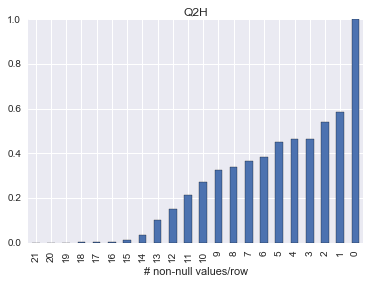

In [149]:
cumsum_dict = {}
na_counts = df_q2h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_dict['Q2H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q2H')

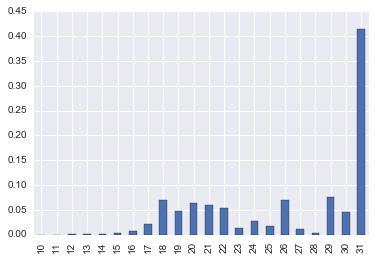

In [116]:
prop.plot.bar()

In [ ]:
df_q6h = df_joined.groupby(level='id').resample(rule='6H',level=column_names.DATETIME).mean()

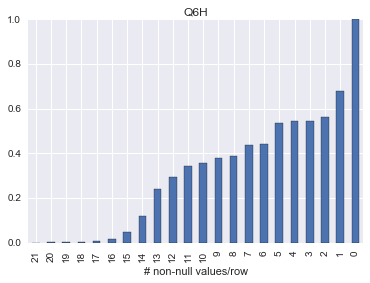

In [150]:
na_counts = df_q6h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_dict['Q6H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q6H')

In [ ]:
df_q12h = df_joined.groupby(level='id').resample(rule='12H',level=column_names.DATETIME).mean()

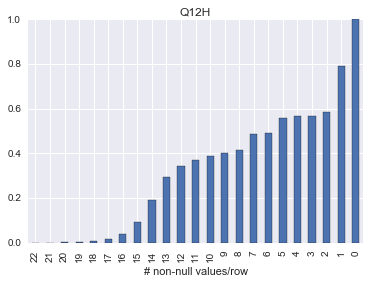

In [151]:
na_counts = df_q12h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_prop.name = 'Q12H'
cumsum_dict['Q12H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q12H')

In [127]:
df_q24h = df_joined.groupby(level='id').resample(rule='24H',level=column_names.DATETIME).mean()

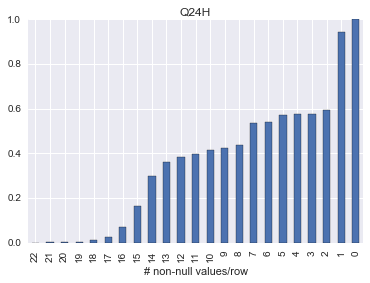

In [152]:
na_counts = df_q24h.apply(pd.isnull).sum(axis=1).value_counts().sort_index()
prop = (na_counts / na_counts.sum())
cumsum_prop = (na_counts.cumsum() / na_counts.sum())
cumsum_prop.index = df_joined.columns.size - cumsum_prop.index
cumsum_prop.index.name = '# non-null values/row'
cumsum_dict['Q24H'] = cumsum_prop
cumsum_prop.plot.bar(title='Q24H')


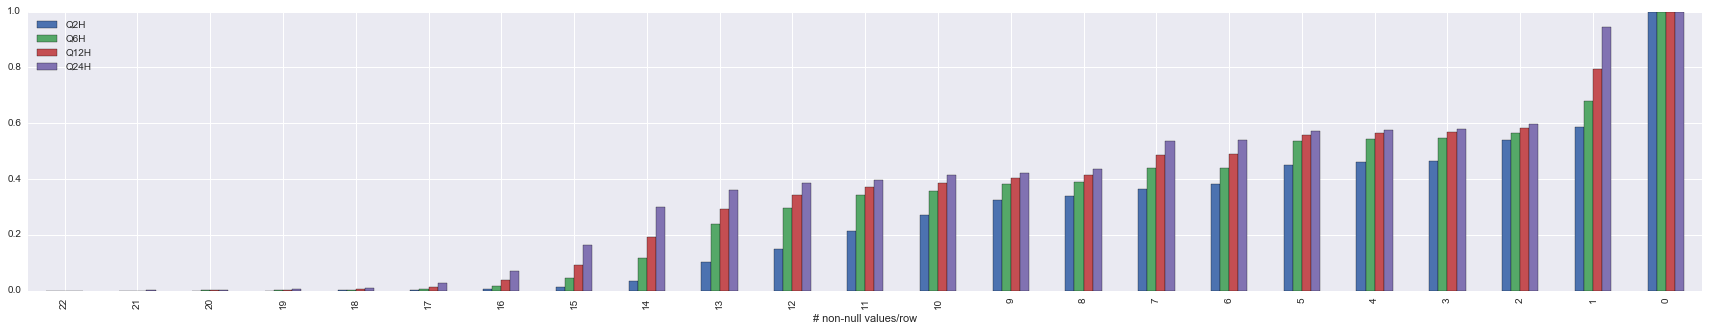

In [162]:
pd.DataFrame(cumsum_dict)[['Q2H','Q6H','Q12H','Q24H']].sort_index(ascending=False).plot.bar(figsize=(30,5))

In [133]:
df_q2h.loc[( df_joined.columns.size - df_q2h.apply(pd.isnull).sum(axis=1) )== 0].dropna(how='all')

Empty DataFrame
Columns: [(blood pressure diastolic, known, qn, mmHg, all), (blood pressure diastolic, unknown, qn, cc/min, all), (blood pressure mean, known, qn, mmHg, all), (blood pressure systolic, known, qn, mmHg, all), (blood pressure systolic, unknown, qn, cc/min, all), (glasgow coma scale eye opening, known, ord, no_units, all), (glasgow coma scale motor, known, ord, no_units, all), (glasgow coma scale verbal, known, ord, no_units, all), (heart rate, known, qn, beats/min, all), (hemoglobin, known, qn, g/dL, all), (lactate, known, qn, mmol/L, all), (lactated ringers, known, qn, mL, all), (lactated ringers, known, qn, mL/hr, all), (lactated ringers, unknown, qn, no_units, all), (norepinephrine, known, qn, mcg, all), (norepinephrine, known, qn, mcg/kg/min, all), (norepinephrine, known, qn, mcg/min, all), (normal saline, known, qn, mL, all), (normal saline, known, qn, mL/hr, all), (output urine, known, qn, mL, all), (output urine, unknown, nom, no_units, 3686(ml)_No Void), (output urine, unknown, nom, no_units, 3686(ml)_Voiding qs), (output urine, unknown, nom, no_units, 3686_Voiding qs), (output urine, unknown, qn, no_units, all), (oxygen saturation pulse oximetry, known, qn, percent, all), (respiratory rate, known, qn, insp/min, all), (respiratory rate, unknown, qn, Breath, all), (temperature body, known, qn, degF, all), (vasopressin, known, qn, units, all), (vasopressin, known, qn, units/min, all), (weight body, known, qn, kg, all)]
Index: []

[0 rows x 31 columns]

In [189]:
df_joined.iloc[:100].groupby(level='id').resample('6H',level=column_names.DATETIME).last().groupby(level='id').ffill()

component                  blood pressure diastolic          \
status                                        known unknown   
variable_type                                    qn      qn   
units                                          mmHg  cc/min   
description                                     all     all   
id     datetime                                               
100029 2185-04-17 12:00:00                      NaN    27.0   
       2185-04-17 18:00:00                      NaN    36.0   
       2185-04-18 00:00:00                      NaN    36.0   
       2185-04-18 06:00:00                      NaN    36.0   
       2185-04-18 12:00:00                      NaN    36.0   
       2185-04-18 18:00:00                      NaN    40.0   
       2185-04-19 00:00:00                      NaN    40.0   
       2185-04-19 06:00:00                      NaN    40.0   
       2185-04-19 12:00:00                      NaN    40.0   
       2185-04-19 18:00:00                      NaN    34.0   
       2185-04-20 00:00:00                      NaN    34.0   
       2185-04-20 06:00:00                      NaN    34.0   
       2185-04-20 12:00:00                      NaN    34.0   
       2185-04-20 18:00:00                      NaN    34.0   
       2185-04-21 00:00:00                      NaN    43.0   
       2185-04-21 06:00:00                      NaN    43.0   
       2185-04-21 12:00:00                      NaN    43.0   

component                  blood pressure mean blood pressure systolic  \
status                                   known                   known   
variable_type                               qn                      qn   
units                                     mmHg                    mmHg   
description                                all                     all   
id     datetime                                                          
100029 2185-04-17 12:00:00                 NaN                     NaN   
       2185-04-17 18:00:00                 NaN                     NaN   
       2185-04-18 00:00:00                 NaN                     NaN   
       2185-04-18 06:00:00                 NaN                     NaN   
       2185-04-18 12:00:00                 NaN                     NaN   
       2185-04-18 18:00:00                 NaN                     NaN   
       2185-04-19 00:00:00                 NaN                     NaN   
       2185-04-19 06:00:00                 NaN                     NaN   
       2185-04-19 12:00:00                 NaN                     NaN   
       2185-04-19 18:00:00                 NaN                     NaN   
       2185-04-20 00:00:00                 NaN                     NaN   
       2185-04-20 06:00:00                 NaN                     NaN   
       2185-04-20 12:00:00                 NaN                     NaN   
       2185-04-20 18:00:00                 NaN                     NaN   
       2185-04-21 00:00:00                 NaN                     NaN   
       2185-04-21 06:00:00                 NaN                     NaN   
       2185-04-21 12:00:00                 NaN                     NaN   

component                          glasgow coma scale eye opening  \
status                     unknown                          known   
variable_type                   qn                            ord   
units                       cc/min                       no_units   
description                    all                            all   
id     datetime                                                     
100029 2185-04-17 12:00:00    52.0                            NaN   
       2185-04-17 18:00:00    60.0                            NaN   
       2185-04-18 00:00:00    60.0                            NaN   
       2185-04-18 06:00:00    60.0                            NaN   
       2185-04-18 12:00:00    60.0                            NaN   
       2185-04-18 18:00:00    54.0                            NaN   
       2185-04-19 0

In [190]:
df_joined.iloc[:100].groupby(level='id').resample('6H',level=column_names.DATETIME).mean()

component                  blood pressure diastolic             \
status                                        known    unknown   
variable_type                                    qn         qn   
units                                          mmHg     cc/min   
description                                     all        all   
id     datetime                                                  
100029 2185-04-17 12:00:00                      NaN  36.333333   
       2185-04-17 18:00:00                      NaN  36.000000   
       2185-04-18 00:00:00                      NaN        NaN   
       2185-04-18 06:00:00                      NaN        NaN   
       2185-04-18 12:00:00                      NaN        NaN   
       2185-04-18 18:00:00                      NaN  40.000000   
       2185-04-19 00:00:00                      NaN        NaN   
       2185-04-19 06:00:00                      NaN        NaN   
       2185-04-19 12:00:00                      NaN        NaN   
       2185-04-19 18:00:00                      NaN  34.000000   
       2185-04-20 00:00:00                      NaN        NaN   
       2185-04-20 06:00:00                      NaN        NaN   
       2185-04-20 12:00:00                      NaN        NaN   
       2185-04-20 18:00:00                      NaN        NaN   
       2185-04-21 00:00:00                      NaN  43.000000   
       2185-04-21 06:00:00                      NaN        NaN   
       2185-04-21 12:00:00                      NaN        NaN   

component                  blood pressure mean blood pressure systolic  \
status                                   known                   known   
variable_type                               qn                      qn   
units                                     mmHg                    mmHg   
description                                all                     all   
id     datetime                                                          
100029 2185-04-17 12:00:00                 NaN                     NaN   
       2185-04-17 18:00:00                 NaN                     NaN   
       2185-04-18 00:00:00                 NaN                     NaN   
       2185-04-18 06:00:00                 NaN                     NaN   
       2185-04-18 12:00:00                 NaN                     NaN   
       2185-04-18 18:00:00                 NaN                     NaN   
       2185-04-19 00:00:00                 NaN                     NaN   
       2185-04-19 06:00:00                 NaN                     NaN   
       2185-04-19 12:00:00                 NaN                     NaN   
       2185-04-19 18:00:00                 NaN                     NaN   
       2185-04-20 00:00:00                 NaN                     NaN   
       2185-04-20 06:00:00                 NaN                     NaN   
       2185-04-20 12:00:00                 NaN                     NaN   
       2185-04-20 18:00:00                 NaN                     NaN   
       2185-04-21 00:00:00                 NaN                     NaN   
       2185-04-21 06:00:00                 NaN                     NaN   
       2185-04-21 12:00:00                 NaN                     NaN   

component                             glasgow coma scale eye opening  \
status                        unknown                          known   
variable_type                      qn                            ord   
units                          cc/min                       no_units   
description                       all                            all   
id     datetime                                                        
100029 2185-04-17 12:00:00  55.333333                            NaN   
       2185-04-17 18:00:00  60.000000                            NaN   
       2185-04-18 00:00:00        NaN                            NaN   
       2185-04-18 06:00:00        NaN                            NaN   
       2185-04-18 12:00:00        NaN                     